## Data Modeling

### Table of contents:
- [Data Import](#Data-Import)
- [Data Cleaning](#Data-Cleaning)
- [Model Preprocessing](#Model-Preprocessing)
- [Data Modeling](#Data-Modeling)
- [Optimized Model: ExtraTrees Classifier](#Optimized-Model:-ExtraTrees-Classifier)
- [Findings and Insights](#Findings-and-Insights)
- [Conclusion](#Conclusion)
- [Recommendations](#Recommendations)
- [References](#References)

In [1]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import where
from numpy import asarray
import re
import matplotlib.pyplot as plt 
from numpy import argmax
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
#from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score,roc_curve
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from matplotlib import pyplot
from keras import backend as K

### Data Import

In [2]:
# Load cleaned_data.csv
df_week_13 = pd.read_csv('../datasets/cleaned_data_week_13.csv')
df_week_14 = pd.read_csv('../datasets/cleaned_data_week_14.csv')

In [3]:
# Merge the 2 dataset
df = pd.concat([df_week_13,df_week_14])

In [4]:
# Number of rows and columns in data
df.shape

(98327, 74)

In [5]:
# Viewing first 5 rows
df.head()

EST_ST  TBIRTH_YEAR  EGENDER  RHISPANIC  RRACE  \
0      48         1989        1          1  White   
1       1         1988        0          1  White   
2       1         1969        1          2  Black   
3       1         1947        1          1  White   
4       1         1980        0          1  White   

                           EEDUC             MS  WRKLOSS  EXPCTLOSS  ANYWORK  \
0              Bachelor's degree  Never Married      0.0        0.0      1.0   
1             Associate's degree        Married      1.0        0.0      1.0   
2  College undergraduate/dropout       Divorced      1.0        1.0      1.0   
3                Graduate degree        Married      0.0        0.0      2.0   
4                Graduate degree        Married      1.0        1.0      1.0   

   ...  PSWHYCHG4  PSWHYCHG5 PSWHYCHG6  PSWHYCHG7  PSWHYCHG8  PSWHYCHG9  \
0  ...        0.0        0.0       0.0        0.0        0.0        0.0   
1  ...        1.0        1.0       0.0        1.0        0.0        1.0   
2  ...        0.0        0.0       0.0        0.0        0.0        0.0   
3  ...        0.0        0.0       0.0        0.0        0.0        0.0   
4  ...        0.0        0.0       0.0        0.0        0.0        0.0   

   INCOME         FOODSUF  HOUSEPAY  INSURED  
0     2.0       Unchanged       Yes  Insured  
1     6.0       Unchanged       Yes  Insured  
2     7.0       Unchanged       Yes  Insured  
3     6.0       Unchanged       Yes  Insured  
4     8.0  Less available       Yes  Insured  

[5 rows x 74 columns]

### Data Cleaning

#### Removing duplicated row

In [6]:
# Checking for duplicated rows
duplicates = df[df.duplicated(keep = False)]
duplicates

EST_ST  TBIRTH_YEAR  EGENDER  RHISPANIC  RRACE              EEDUC  \
13531      20         1981        1          1  White  Bachelor's degree   
47899      20         1981        1          1  White  Bachelor's degree   

            MS  WRKLOSS  EXPCTLOSS  ANYWORK  ...  PSWHYCHG4  PSWHYCHG5  \
13531  Married      0.0        0.0      1.0  ...        0.0        0.0   
47899  Married      0.0        0.0      1.0  ...        0.0        0.0   

      PSWHYCHG6  PSWHYCHG7  PSWHYCHG8  PSWHYCHG9  INCOME    FOODSUF  HOUSEPAY  \
13531       0.0        0.0        0.0        0.0     6.0  Unchanged       Yes   
47899       0.0        0.0        0.0        0.0     6.0  Unchanged       Yes   

       INSURED  
13531  Insured  
47899  Insured  

[2 rows x 74 columns]

In [7]:
# Randomly keeping one of the rows
df = df.drop_duplicates(keep = 'first')

#### Final check for null values

In [8]:
# Checking for null values
null_columns = df.columns[df.isnull().any()]
null_columns

Index([], dtype='object')

### Feature Engineering 

#### Ordinal encoding for ordinal features
To preserve the order and reduce the number of features

In [9]:
df['EXPNS_DIF'].value_counts()

Not at all difficult    51592
A little difficult      20914
Somewhat difficult      15000
Very difficult          10820
Name: EXPNS_DIF, dtype: int64

In [10]:
# For EXPNS_DIF
encoder = OrdinalEncoder(categories = [['Not at all difficult','A little difficult','Somewhat difficult','Very difficult']])
df['EXPNS_DIF'] = encoder.fit_transform(df['EXPNS_DIF'].values.reshape(-1,1))

In [11]:
df['FOODCONF'].value_counts()

Very Confident          55561
Moderately Confident    19545
Somewhat confident      16994
Not at all confident     6161
Missing                    65
Name: FOODCONF, dtype: int64

In [12]:
# For FOODCONF: 
encoder = OrdinalEncoder(categories = [['Missing','Very Confident','Moderately Confident','Somewhat confident','Not at all confident']])
df['FOODCONF'] = encoder.fit_transform(df['FOODCONF'].values.reshape(-1,1))

In [13]:
df['HLTHSTATUS'].value_counts()

Very Good    34879
Good         27450
Excellent    19893
Fair         12896
Poor          3107
Missing        101
Name: HLTHSTATUS, dtype: int64

In [14]:
# For HLTHSTATUS: 
encoder = OrdinalEncoder(categories = [['Missing','Excellent','Very Good','Good','Fair','Poor']])
df['HLTHSTATUS'] = encoder.fit_transform(df['HLTHSTATUS'].values.reshape(-1,1))

In [15]:
df['ANXIOUS'].value_counts()

Not at all                 33076
Several days               32003
Everyday                   19566
More than half the days    13531
Missing                      150
Name: ANXIOUS, dtype: int64

In [16]:
# For ANXIOUS
encoder = OrdinalEncoder(categories = [['Missing','Not at all','Several days','More than half the days','Everyday']])
df['ANXIOUS'] = encoder.fit_transform(df['ANXIOUS'].values.reshape(-1,1))

In [17]:
df['DOWN'].value_counts()

Not at all                 46588
Several days               30980
Everyday                   10778
More than half the days     9806
Missing                      174
Name: DOWN, dtype: int64

In [18]:
# For DOWN
encoder = OrdinalEncoder(categories = [['Missing','Not at all','Several days','More than half the days','Everyday']])
df['DOWN'] = encoder.fit_transform(df['DOWN'].values.reshape(-1,1))

In [19]:
df['FOODSUF'].value_counts()

Unchanged         77835
Less available    15177
More available     5030
Missing             284
Name: FOODSUF, dtype: int64

In [20]:
# For FOODSUF
encoder = OrdinalEncoder(categories = [['Missing','More available','Unchanged','Less available']])
df['FOODSUF'] = encoder.fit_transform(df['FOODSUF'].values.reshape(-1,1))

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98326 entries, 0 to 8868
Data columns (total 74 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EST_ST       98326 non-null  int64  
 1   TBIRTH_YEAR  98326 non-null  int64  
 2   EGENDER      98326 non-null  int64  
 3   RHISPANIC    98326 non-null  int64  
 4   RRACE        98326 non-null  object 
 5   EEDUC        98326 non-null  object 
 6   MS           98326 non-null  object 
 7   WRKLOSS      98326 non-null  float64
 8   EXPCTLOSS    98326 non-null  float64
 9   ANYWORK      98326 non-null  float64
 10  UI_APPLY     98326 non-null  float64
 11  SSA_RECV     98326 non-null  float64
 12  EXPNS_DIF    98326 non-null  float64
 13  WHYCHNGD1    98326 non-null  float64
 14  WHYCHNGD2    98326 non-null  float64
 15  WHYCHNGD3    98326 non-null  float64
 16  WHYCHNGD4    98326 non-null  float64
 17  WHYCHNGD5    98326 non-null  float64
 18  WHYCHNGD6    98326 non-null  float64
 19  WHYCH

#### Data Dictionary

|Feature|Type|Dataset|Description|
|:---|:---|:---|:---|
|EST_ST|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|State|
|TBIRTH_YEAR|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Year of Birth|
|EGENDER|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Gender|
|RHISPANIC|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Hispanic Origin|
|RRACE|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Race|
|EEDUC|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Educational attainment|
|MS|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Marital Status|
|WRKLOSS|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Recent household job loss|
|EXPCTLOSS|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Expect household job loss|
|ANYWORK|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Employment status for last 7 days|
|UI_APPLY|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Applied for Unemployment Insurance(UI)|
|SSA_RECV|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|State of receiving Social Security Benefits|
|EXPNS_DIF|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Difficult with expenses|
|WHYCHNGD1|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to shopping places restrictions|
|WHYCHNGD2|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to re-opening/extension of stores'operation duration|
|WHYCHNGD3|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to avoidance of crowded/high-risk public areas|
|WHYCHNGD4|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to lack of avoidance of crowded/high-risk public areas|
|WHYCHNGD5|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to loss of income|
|WHYCHNGD6|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to increase in income|
|WHYCHNGD7|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to concerns about unemployment/reduced work hours|
|WHYCHNGD8|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to lack of concerns about unemployment/reduced work hours|
|WHYCHNGD9|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to working from home/teleworking|
|WHYCHNGD10|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to resumed working onsite at workplace|
|WHYCHNGD11|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to concerns about economy|
|WHYCHNGD12|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to lack of concerns about economy|
|WHYCHNGD13|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Change in household spending due to other reasons|
|SPNDSRC1|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Similar income sources as pre-covid|
|SPNDSRC2|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - credit cards/loans|
|SPNDSRC3|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Money from savings/selling assets|
|SPNDSRC4|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Borrow from friends/family|
|SPNDSRC5|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Unemployment Insurance(UI) benefit payments|
|SPNDSRC6|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Stimulus(economic impact) payment|
|SPNDSRC7|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Money saved from deferred/forgiven payments|
|SPNDSRC8|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Source of spending needs - Supplemental Nutrition Assistance Program(SNAP)|
|FREEFOOD|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Retrival of free groceries/meal in last 7 days|
|WHEREFREE1|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/meal - School programmes|
|WHEREFREE2|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/meal - Food pantry/food bank|
|WHEREFREE3|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/Home delivered meal service|
|WHEREFREE4|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/meal - Religious organizations|
|WHEREFREE5|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/Shelter/soup kitchen|
|WHEREFREE6|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/meal - Other community programmes|
|WHEREFREE7|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Sources of free groceries/meal - Family,friends,neighbors|
|SNAP_YN|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Subscription to Supplemental Nutrition Assistance Program(SNAP)|
|TSPNDFOOD|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Househol money spent in last 7 days on prepared meals|
|FOODCONF|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Food sufficiency confidence for next 4 weeks|
|HLTHSTATUS|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|General health status|
|ANXIOUS|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Frequency of anxiety over previous 7 days|
|DOWN|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Frequency of feeling depressed over previous 7 days|
|PRIVHLTH|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Ownership of private health insurance|
|PUBHLTH|int|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Ownership of public health insurance|
|DELAY|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Delay of medical care in due to pandemic|
|PRESCRIPT|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Taking prescription medicine for mental health|
|MH_SVCS|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Receive professional mental health services|
|MH_NOTGET|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Require mental help but did not get it|
|TENURE|obj|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Status of housing ownership(owned/rented)|
|PSPLANS1|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Diploma/occupational training|
|PSPLANS2|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Associate's degree programme|
|PSPLANS3|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Bachelor's degree programme|
|PSPLANS4|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Graduate degree programme|
|PSPLANS5|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Other credential programme|
|PSPLANS6|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Type of post-sec programme expected to take - Classes that are not part of credential programmes|
|PSWHYCHG1|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Had coronavirus/concerns about getting the virus|
|PSWHYCHG2|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Caring for someone who coronavirus|
|PSWHYCHG3|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Caring for others whose care arrangements are disrupted|
|PSWHYCHG4|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Institution changed content/format of classes|
|PSWHYCHG5|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Changes to financial aid|
|PSWHYCHG6|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - changes to campus life|
|PSWHYCHG7|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Uncertainty about how classes/programmes might change|
|PSWHYCHG8|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Unable to afford classes/educational expenses because of income changes due to pandemic|
|PSWHYCHG9|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Reasons for post-sec educational plans change - Other reasons related to the pandemic|
|INCOME|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Total household income|
|FOODSUF|float|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Food sufficiency prior to March 13|
|HOUSEPAY|object|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Abiltiy to support housing payments|
|INSURED|object|cleaned_data_week_13.csv/cleaned_data_week_14.csv|Presence of insurance|

In [22]:
# Converting EST_ST to its respective state for data visualization purposes
df['STATE'] = df['EST_ST'].map({
    1:'Alabama',
    2:'Alaska',
    4:'Arizona',
    5:'Arkansas',
    6:'California',
    8:'Colorado',
    9:'Connecticut',
    10:'Delaware',
    11:'District of Columbia',
    12:'Florida',
    13:'Georgia',
    15:'Hawaii',
    16:'Idaho',
    17:'Illinois',
    18:'Indiana',
    19:'Iowa',
    20:'Kansas',
    21:'Kentucky',
    22:'Louisiana',
    23:'Maine',
    24:'Maryland',
    25:'Massachusetts',
    26:'Michigan',
    27:'Minnesota',
    28:'Mississippi',
    29:'Missouri',
    30:'Montana',
    31:'Nebraska',
    32:'Nevada',
    33:'New Hampshire',
    34:'New Jersey',
    35:'New Mexico',
    36:'New York',
    37:'North Carolina',
    38:'North Dakota',
    39:'Ohio',
    40:'Oklahoma',
    41:'Oregon',
    42:'Pennsylvania',
    44:'Rhode Island',
    45:'South Carolina',
    46:'South Dakota',
    47:'Tennessee',
    48:'Texas',
    49:'Utah',
    50:'Vermont',
    51:'Virginia',
    53:'Washington',
    54:'West Virginia',
    55:'Wisconsin',
    56:'Wyoming'
    

})

In [147]:
# Saving final df as final.csv
df.to_csv('../datasets/final.csv',index = False)

#### One hot encoding for the remaining nominal features

In [23]:
# Removing state column
df.drop(columns = ['STATE'],inplace = True)

In [24]:
# One hot encoding for all categorical variables
dummy_df = pd.get_dummies(data = df)

In [25]:
dummy_df.shape

(98326, 105)

### Feature Selection  

Feature selection is important in reducing the complexity of our model, reduces the likelihood of overfitting and allowing it to run faster. 

#### 1. Pearson's Chi Square test
Calculation of chi square values to quantify relationship between y target variable and X categorical variables. Strength of association would determine likelihood of reflecting their true relationship in the population. Higher chi square values and therefore lower p-values indicates that there is more evidence to reject the null hypothesis and thus conclude that there is a correlation between predictor feature and target feature.

$$ H_0: \text{X predictor feature and y target variable are independent.} $$

$$ H_A: \text{X predictor feature and y target variable are not independent.} $$


In [26]:
# Splitting into X and y variables
X = dummy_df.drop(columns = ['MH_NOTGET'])
y = dummy_df['MH_NOTGET']

In [27]:
# Calculating chi square scores 
chi_scores = chi2(X,y)
# Extracting p-values into a new p_values dataframe
p_values = pd.DataFrame({'chi_scores':chi_scores[0], # actual chi square scores
                         'p_values': chi_scores[1], # derived p-values
                         'features': X.columns}) 
p_values.sort_values(by = 'p_values',ascending = False,inplace= True)

# Only including dependent variables at 95% confidence interval
impt_features = p_values[p_values['p_values'].apply(lambda x:x < 0.05)]
print(f'Number of predictor features remaining: {len(impt_features)}')

# Removing independent/redundant features from X
X_cleaned = X[[col for col in impt_features['features']]]


Number of predictor features remaining: 92


In [28]:
print(f'Original number of features: {X.shape[1]}')

Original number of features: 104


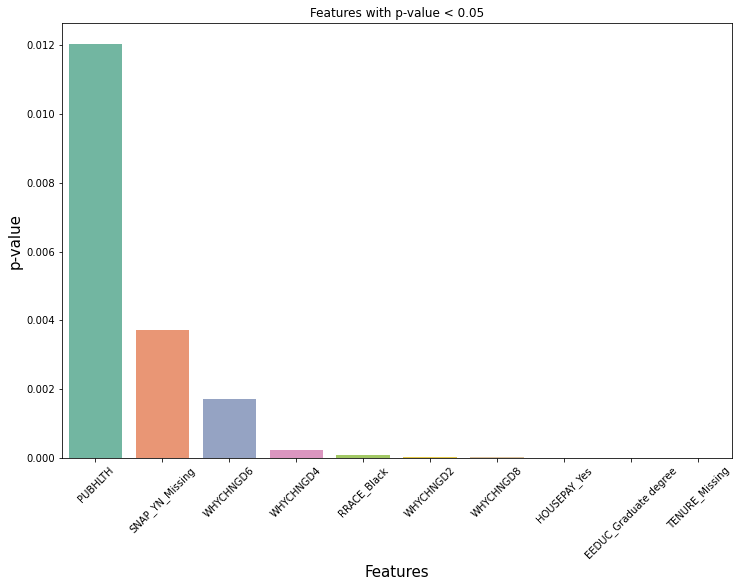

In [29]:
# Viewing redundant features
plt.figure(figsize = (12,8))
sns.barplot(x = impt_features['features'][:10], y = impt_features['p_values'][:10], palette = 'Set2' )

# Set title
plt.title("Features with p-value < 0.05")

# Set xticks
plt.xticks(rotation = 45)

# Set xlabel
plt.xlabel('Features',fontsize = 15)

# Set ylabel
plt.ylabel('p-value',fontsize = 15);

### Model Preprocessing

#### Train-test split

In [30]:
# Train-test split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y,random_state = 42)

#### Model scoring metric
The scoring metric used would be ROC-AUC which indicates how well our model is able to distinguish the `MH_NOTGET` classes. Moreover, since the cost of misdiagnosing a patient is high, the recall score would be also be used to measure the performance of our model.

#### StandardScaler
Feature scaling to ensure that variance of variables are in the same range. This is important when implementing classification and clustering models such as k-NN which uses distance metrics to group data. Moreover, scaling is important for deep learning algorithms that use gradient descent as an optimization technique.

In [31]:
# Instantiating StandardScaler
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

#### Undersampling majority class using `RandomUnderSample` to obtain balanced classes

In [32]:
# Undersample the majority class to achieve a more balanced dataset
rus = RandomUnderSampler(random_state = 42)


X_train_us,y_train_us = rus.fit_resample(X_train_ss,y_train)

counter = Counter(y_train_us)
print(counter)


Counter({0.0: 13075, 1.0: 13075})


#### Machine learning models to be used

In [33]:
# Models to be used
model_dict = {
    'lr': LogisticRegression(),
    'knn':KNeighborsClassifier(),
    'rf':RandomForestClassifier(),
    'et':ExtraTreesClassifier(),
    'xgb':XGBClassifier(),
    'svm': SVC()
    
}

# Names of models for ease of reference
model_name = {
    'lr':'Logistic Regression',
    'knn':'KNeighborsClassifier',
    'rf':'Random Forest',
    'et':'ExtraTrees',
    'xgb': 'XGBoost Classifier',
    'svm':'Support Vector Machine'
}

# Pipeline for easy of implementation of models
def pipeline(model):
    pipe = Pipeline([(model,model_dict[model])])
    return pipe

def params(model):
    if model == 'lr':
        return {'lr__penalty':['l1','l2','enet'],
               'lr__C':np.linspace(0.001,0.01,10)}
    
    elif model == 'knn':
        return {'knn__n_neighbors':[50,70,90,110]}
    
    elif model == 'rf':
        return {'rf__n_estimators':[50,100,150,200],
               'rf__max_depth':[20,25,30,40,50],
               'rf__max_features': ['auto'],
               'rf__min_samples_leaf':[10,20,30],
               'rf__class_weight':['balanced']}
    
    elif model == 'et':
        return {'et__n_estimators':[50,100,150,200],
               'et__max_depth':[20,25,30,40,50],
               'et__max_features': ['auto'],
               'et__min_samples_leaf':[10,20,30],
               'et__class_weight':['balanced']}
    
    elif model == 'svm':
        return {'svm__C':np.linspace(0.01,10,10),
               'svm__kernel':['linear','poly','rbf'],
               'svm__gamma':['auto','scale']}
    elif model == 'xgb':
        return {
            'xgb__early_stopping_rounds':[10,20,30],
            'xgb__eval_metric' : ['logloss'],
            'xgb__subsample' : [0.8], 
            'xgb__colsample_bytree' : [0.5], 
            'xgb__learning_rate' : [0.1],
            'xgb__max_depth' : [10,20,30], 
            'xgb__scale_pos_weight': [5], 
            'xgb__n_estimators' : [100,200],
            'xgb__reg_alpha' : [0, 0.05],
            'xgb__reg_lambda' : [2,3],
            'xgb__gamma' : [0.01]
                             
        }
    
        
def grid_search(model,X_train = X_train_us,y_train = y_train_us,X_test = X_test_ss,y_test=y_test):
    pipe_params = params(model)
    pipe = pipeline(model)
    gs = GridSearchCV(pipe,param_grid = pipe_params,cv = 5,scoring = 'recall', verbose=True, n_jobs=8)
    gs_fit = gs.fit(X_train,y_train)
    
    print(f'Results from: {model_name[model]}')
    print(f'-----------------------------------')
    print(f'Best Hyperparameters: {gs.best_params_}')
    print(f'-----------------------------------')
    print('Scores:')
    print(f'-----------------------------------')
    print('')
    print(f'Mean recall score: {round(gs.best_score_,4)}')

    print(f'Train recall Score: {round(gs.score(X_train,y_train),4)}')
    print("Train F1 score:", round(f1_score(y_train, gs.best_estimator_.predict(X_train)),4))  
    print("Train ROC-AUC score:", round(roc_auc_score(y_train, gs.best_estimator_.predict(X_train)),4))
    
    print(' ')
    print(f'Test recall Score: {round(gs.score(X_test,y_test),4)}')
    print("Test F1 score:", round(f1_score(y_test, gs.best_estimator_.predict(X_test)),4))  
    print("Test ROC-AUC score:", round(roc_auc_score(y_test, gs.best_estimator_.predict(X_test)),4))

    cm = confusion_matrix(y_test, gs.best_estimator_.predict(X_test))
    cm_df = pd.DataFrame(data = cm, columns = ['predict_mh_negative','predict_mh_positive'], index =['actual_mh_negative','actual_mh_positive'])
    return cm_df
            
    

#### Neural Nets architecture

In [34]:
# Testing out different n_components
def pca_ratio(n,X_train_ss,X_test_ss):
    pca = PCA(n)
    X_train_pca = pca.fit_transform(X_train_ss)
    X_test_pca = pca.transform(X_test_ss)
    return X_train_pca,X_test_pca

pipe_params = {
    'epochs':[20,30,40],
    'dropout_rate':[0.4,0.5,0.6]
}


reg_pipe_params = {
    'epochs':[20,30,40],
    'dropout_rate':[0.4,0.5,0.6],
    'C':[i for i in np.linspace(0.01,0.1,5)]
}


# Definiting pipeline for neural nets
def algorithm_pipeline(X_train, X_test,  y_train, y_test, 
                       model, param_grid , cv=5,
                       ):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring = 'accuracy',
        verbose=2
    )
    fitted_model = gs.fit(X_train, y_train)
    
    
    return fitted_model

# Building architecture for neural nets - without PCA

def basic_nn(activation = 'relu',dropout_rate = 0.3, opt_learning_rate = 0.01):
    model = Sequential()
    model.add(Dense(X_train_us.shape[1],activation = 'relu',input_dim = X_train_us.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation= 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = [recall_m])
    return model

# Building architecture for neural nets - with PCA
def build_nn(activation = 'relu',dropout_rate = 0.3,opt_learning_rate = 0.01):
    model = Sequential()
    model.add(Dense(X_train_pca.shape[1],activation = 'relu',input_dim = X_train_pca.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))

    model.compile(loss= 'binary_crossentropy',optimizer = 'adam' ,metrics = [recall_m])
    return model

# Scoring metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


## Data Modeling

### Naive classifier
The naive classifier would be used as a performance baseline for imbalanced datasets and the ROC-AUC scoring metric would be implemented

In [35]:
# Instantiate a baseline classifier
dummy = DummyClassifier(strategy = 'stratified',random_state = 42) 
dummy.fit(X,y)

# Calculate baseline ROC-AUC and recall score 
roc_auc_avg = cross_val_score(dummy,X,y,cv = 5,scoring = 'roc_auc').mean()
recall_avg = cross_val_score(dummy,X,y,cv = 5,scoring = 'recall').mean()
print(f'Baseline ROC-AUC : {round(roc_auc_avg,3)}')
print(f'Baseline recall: {round(recall_avg,3)}')

Baseline ROC-AUC : 0.502
Baseline recall: 0.179


### Logistic Regression

In [161]:
grid_search('lr')

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  60 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.4s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.01, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.781
Train recall Score: 0.783
Train F1 score: 0.7809
Train ROC-AUC score: 0.7803
 
Test recall Score: 0.8008
Test F1 score: 0.5676
Test ROC-AUC score: 0.7904


predict_mh_negative  predict_mh_positive
actual_mh_negative                15774                 4450
actual_mh_positive                  868                 3490

In [162]:
# Instantiate and fit model with optimal hyperparameters
lr = LogisticRegression(C = 0.01,penalty = 'l2')
lr.fit(X_train_us,y_train_us)
roc_auc_mean = cross_val_score(lr,X_train_us,y_train_us,cv = 5,scoring = 'roc_auc').mean()
print(f'Mean ROC-AUC score: {roc_auc_mean:.3f}')

Mean ROC-AUC score: 0.861


#### Logistic Regression - Viewing feature importance

In [163]:
# Dictionary to store features and respective coefficients
coef_dict = {}
for coef,feature in zip(lr.coef_.ravel(),X_train.columns):
    coef_dict[feature] = coef

In [164]:
# Sorting features according to their coefficients in descending order
sorted_coef_dict = {
    k:v for (k,v) in sorted(coef_dict.items(),key = lambda x: abs(x[1]),reverse = True)}

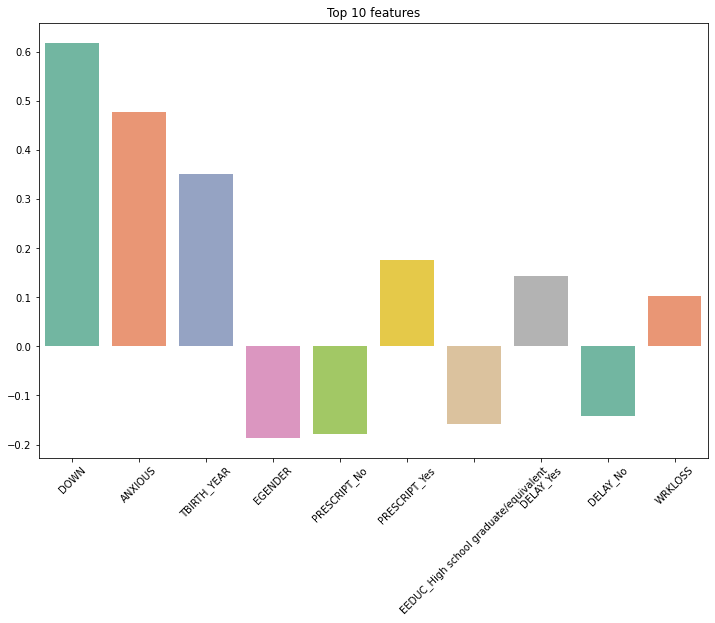

In [165]:
# Viewing top10 important features in determining MH_NOTGET
top_10 = {k:v for k,v in [x for x in sorted_coef_dict.items()][:10]}
plt.figure(figsize = (12,8))
sns.barplot(x = [x for x in top_10.keys()],y = [i for i in top_10.values()],palette = 'Set2')
plt.title('Top 10 features')
plt.xticks(rotation = 45);

### Xgboost Classifier

In [113]:
# Data modeling with XgBoost
grid_search('xgb')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  8.3min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 17.8min finished


[11:31:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9413
Train recall Score: 0.9957
Train F1 score: 0.8597
Train ROC-AUC score: 0.8375
 
Test recall Score: 0.9514
Test F1 s

predict_mh_negative  predict_mh_positive
actual_mh_negative                11341                 8883
actual_mh_positive                  212                 4146

Based on the huge decrease in F1 score, the test precision score is very poor and thus the model is predicting many false positives. Moreover, there are also signs of overfitting as the train ROC-AUC score is higher than that of the test set. 

### RandomForests

In [43]:
grid_search('rf')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 450 out of 450 | elapsed:  5.3min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 200}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8398
Train recall Score: 0.8747
Train F1 score: 0.8331
Train ROC-AUC score: 0.8248
 
Test recall Score: 0.8472
Test F1 score: 0.549
Test ROC-AUC score: 0.7901


predict_mh_negative  predict_mh_positive
actual_mh_negative                14825                 5399
actual_mh_positive                  666                 3692

#### RandomForests - ROC AUC

In [89]:
# Instantiate and fit model with optimized hyperparamters
rf = RandomForestClassifier(max_depth = 20,max_features = 'auto',min_samples_leaf = 10, n_estimators = 200,class_weight = 'balanced')
mean_roc_auc = cross_val_score(rf,X_train_us,y_train_us, cv = 5,scoring = 'roc_auc').mean()
print(f' Mean ROC-AUC score: {mean_roc_auc:.3f}')

 Mean ROC-AUC score: 0.863


#### RandomForests - Feature importance

In [51]:
# Viewing the top 10 features identifed by RandomForests
rf.fit(X_train_us,y_train_us)
feature_importance_rf = sorted(zip(map(lambda x: round(x,4),rf.feature_importances_),labels),reverse = True)
feature_importance_rf[:10]

[(0.2239, 'DOWN'),
 (0.1803, 'ANXIOUS'),
 (0.0567, 'TBIRTH_YEAR'),
 (0.0537, 'PRESCRIPT_No'),
 (0.0481, 'PRESCRIPT_Yes'),
 (0.0445, 'DELAY_No'),
 (0.041, 'DELAY_Yes'),
 (0.0327, 'EXPNS_DIF'),
 (0.0209, 'FOODCONF'),
 (0.0203, 'EST_ST')]

### ExtraTreesClassifier

In [38]:
grid_search('et')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   23.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  3.0min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 10, 'et__n_estimators': 200}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8272
Train recall Score: 0.8699
Train F1 score: 0.8369
Train ROC-AUC score: 0.8304
 
Test recall Score: 0.838
Test F1 score: 0.5493
Test ROC-AUC score: 0.7883


predict_mh_negative  predict_mh_positive
actual_mh_negative                14936                 5288
actual_mh_positive                  706                 3652

The ExtraTrees Classifier has similar scores as RandomForests but they are computationally more efficient than the RandomForests classifier.

#### ExtraTreesClassifier - Feature Importance

In [88]:
# Instantiate model with optimized hyperparameters
et = ExtraTreesClassifier(class_weight = 'balanced',max_depth = 30,max_features = 'auto',min_samples_leaf = 10,n_estimators = 200)
mean_roc_auc = cross_val_score(et,X_train_us,y_train_us, cv = 5,scoring = 'roc_auc').mean()
print(f' Mean ROC-AUC score: {mean_roc_auc:.3f}')

 Mean ROC-AUC score: 0.860


In [55]:
# Features and their corresponding coefficients
labels = X_train.columns
et.fit(X_train_us,y_train_us)
feature_importance_et = sorted(zip(map(lambda x: round(x,4),et.feature_importances_),labels),reverse = True)

In [57]:
# Viewing the top 10 features identifed by ExtraTrees
feature_importance_et[:10]

[(0.1767, 'ANXIOUS'),
 (0.1754, 'DOWN'),
 (0.0707, 'DELAY_Yes'),
 (0.0632, 'PRESCRIPT_Yes'),
 (0.0611, 'PRESCRIPT_No'),
 (0.0561, 'DELAY_No'),
 (0.0406, 'EXPNS_DIF'),
 (0.025, 'TBIRTH_YEAR'),
 (0.0234, 'WHYCHNGD5'),
 (0.0163, 'EGENDER')]

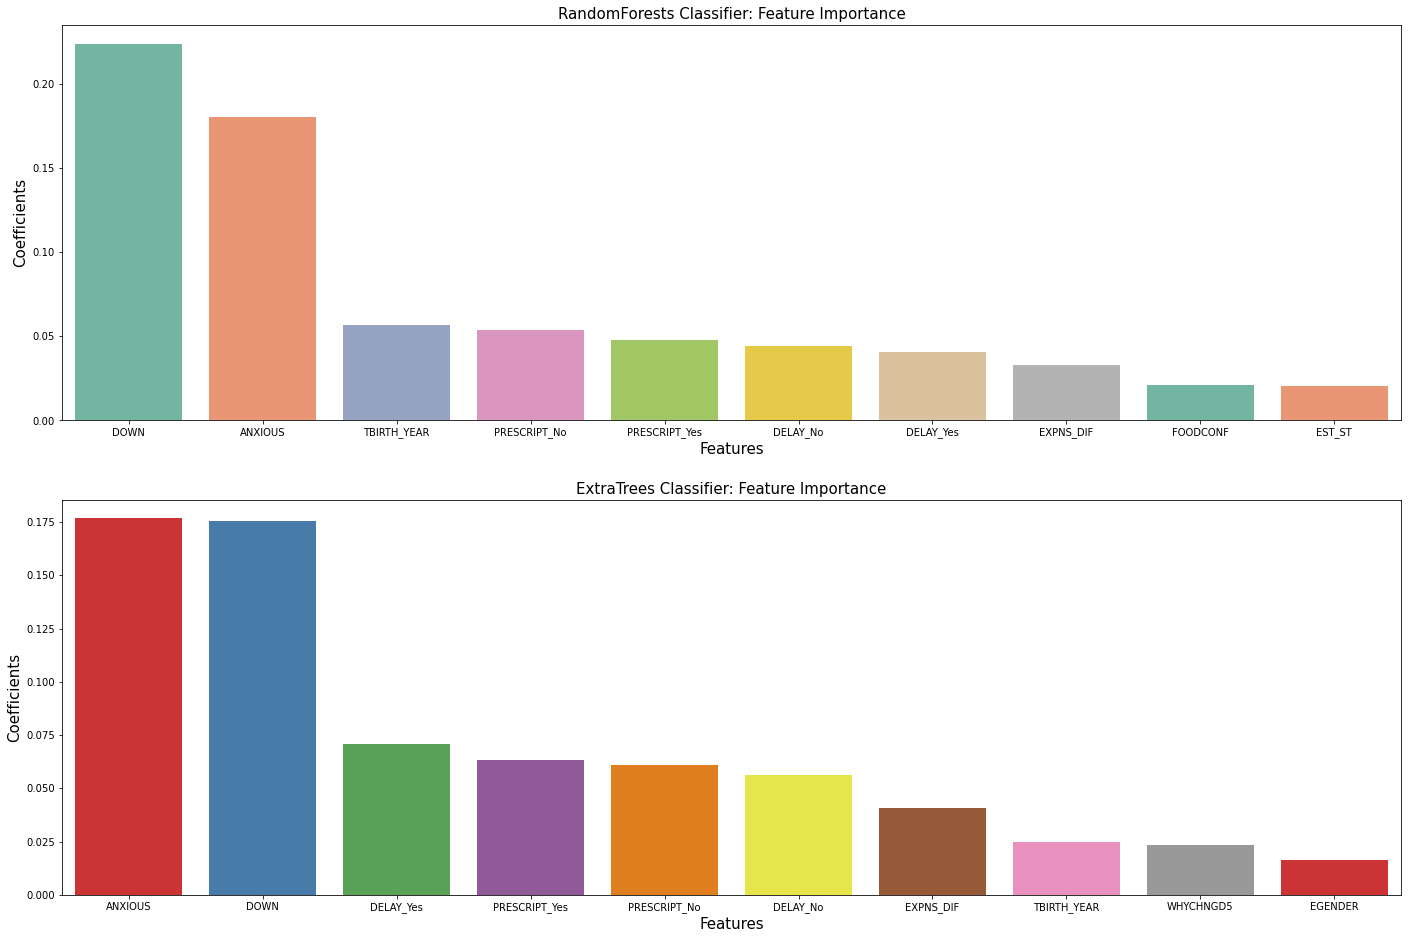

In [86]:
# Visualizing important features using RandomForest and ExtraTrees
fig,axes = plt.subplots(2,1,figsize = (24,16))

# RandomForest features:
sns.barplot(x = [j for i,j in feature_importance_rf[:10]], y = [i for i,j in feature_importance_rf[:10]],ax = axes[0],palette = 'Set2')

# Set title
axes[0].set_title("RandomForests Classifier: Feature Importance",fontsize = 15)
# Set x label
axes[0].set_xlabel('Features',fontsize = 15)
# Set y label
axes[0].set_ylabel('Coefficients',fontsize = 15)

# ExtraTrees features:
sns.barplot(x = [j for i,j in feature_importance_et[:10]],y = [i for i,j in feature_importance_et[:10]],ax = axes[1],palette = 'Set1')

# Set title
axes[1].set_title("ExtraTrees Classifier: Feature Importance",fontsize = 15)
# Set x label
axes[1].set_xlabel('Features',fontsize = 15)
# Set y label
axes[1].set_ylabel('Coefficients',fontsize = 15);


### k-NN

In [90]:
grid_search('knn')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.2min finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.6875
Train recall Score: 0.7075
Train F1 score: 0.7451
Train ROC-AUC score: 0.758
 
Test recall Score: 0.7097
Test F1 score: 0.5332
Test ROC-AUC score: 0.7523


predict_mh_negative  predict_mh_positive
actual_mh_negative                16074                 4150
actual_mh_positive                 1265                 3093

### Neural Nets

In [51]:
# Vanilla neural nets
model = KerasClassifier(build_fn = basic_nn, verbose=0)
model = algorithm_pipeline(X_train = X_train_us, X_test = X_test_ss, y_train =  y_train_us, y_test = y_test, model = model, 
                                        param_grid = pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_us)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_ss)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.5min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.6, 'epochs': 30}
Mean recall score: 0.7102
------------------------------
Train recall score: 0.8577
Train F1 score: 0.8217
Train ROC-AUC:0.8139
------------------------------
Test recall score: 0.8414
Test F1 score :0.5569
Test ROC-AUC:0.7935
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        15080                         5144
actual_does_not_get_help                  691                         3667

#### Comparison of recall and ROC-AUC scores across models

|Models |CV recall score |Train recall score |Test recall score |Train ROC-AUC | Test ROC-AUC 
|---	|---	  |---	       |---	            |---	    |---      
|Logistic Regression 	|0.781 |0.783          	|0.802   	|0.780   	|0.790     
|XGBoost 	            |0.941 |0.996          	|0.951  	|0.838   	|0.756     
|Random Forest 	        |0.840 |0.875          	|0.847   	|0.825   	|0.790    
|Extra Trees   	        |0.827 |0.870   	    |0.838   	|0.830   	|0.788     
|k-NN                   |0.688 |0.708 	        |0.710   	|0.758   	|0.752  
|Neural Nets            |0.710 |0.856           |0.841      |0.814      |0.794              

#### 1) Train scores are generally larger than test scores
Comparing the train and test scores, train scores for both recall and ROC-AUC are generally larger than that of the test scores across all models. This might be due to the high variance of the model and thus model is overfitted with the training data. Several techniques can be implemented to reduce overfitting and one such example would be the use of principal component analysis(PCA)

#### 2) Large difference in CV recall score and train recall score for neural nets
The model does not perform well on the validation set and therefore mean CV recall score is much lower. This means that there is high variance and model does not generalize well to unseen data. When fitted with the entire training dataset, the recall score is much higher than thus supports the explanation that model is overfitted with the training dataset. A few ways to reduce variance and thus overfitting would be to use techniques such as feature engineering, model regularization and early stopping.

### Feature Engineering - PCA

Since most models show signs of overfitting with the training data, PCA can be done as a form of feature extraction which extracts the principal components of data and transform them in the preprocessing step. Some benefits include a reduction in computational efficiency,noise reduction and copes with multicollinearity. Dimensionality reduction zeros out the less important components, leading to a lower-dimensional projection of the data that preserves the maximal data variance.

#### Logistic Regression + PCA

In [58]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'pca:{i}')
    X_train_pca,X_test_pca = pca_ratio(i,X_train_us,X_test_ss)
    grid_search('lr',X_train = X_train_pca,X_test= X_test_pca)
    print('**********************')

pca:0.1
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.5s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.004, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.6688
Train recall Score: 0.6687
Train F1 score: 0.6927
Train ROC-AUC score: 0.7033
 
Test recall Score: 0.695
Test F1 score: 0.4768
Test ROC-AUC score: 0.716
**********************
pca:0.2
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.9s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.009000000000000001, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7258
Train recall Score: 0.7263
Train F1 score: 0.7325
Train ROC-AUC score: 0.7348
 
Test recall Score: 0.7492
Test F1 score: 0.5145
Test ROC-AUC score: 0.7493
**********************
pca:0.3
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    0.8s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.009000000000000001, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7433
Train recall Score: 0.7431
Train F1 score: 0.7454
Train ROC-AUC score: 0.7462
 
Test recall Score: 0.7634
Test F1 score: 0.5223
Test ROC-AUC score: 0.7567
**********************
pca:0.4
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.1s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.007, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7601
Train recall Score: 0.76
Train F1 score: 0.7613
Train ROC-AUC score: 0.7617
 
Test recall Score: 0.7797
Test F1 score: 0.5388
Test ROC-AUC score: 0.7698
**********************
pca:0.5
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.3s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.002, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7626
Train recall Score: 0.7631
Train F1 score: 0.7632
Train ROC-AUC score: 0.7633
 
Test recall Score: 0.7861
Test F1 score: 0.5429
Test ROC-AUC score: 0.7735
**********************
pca:0.6
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    1.5s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.005, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7651
Train recall Score: 0.7642
Train F1 score: 0.7653
Train ROC-AUC score: 0.7656
 
Test recall Score: 0.791
Test F1 score: 0.5488
Test ROC-AUC score: 0.7779
**********************
pca:0.7
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 135 out of 150 | elapsed:    1.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.0s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.008, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7731
Train recall Score: 0.7751
Train F1 score: 0.7739
Train ROC-AUC score: 0.7736
 
Test recall Score: 0.7944
Test F1 score: 0.5587
Test ROC-AUC score: 0.7842
**********************
pca:0.8
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.4s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.001, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7764
Train recall Score: 0.7769
Train F1 score: 0.7752
Train ROC-AUC score: 0.7746
 
Test recall Score: 0.7994
Test F1 score: 0.5619
Test ROC-AUC score: 0.787
**********************
pca:0.9
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 135 out of 150 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:    2.6s finished


Results from: Logistic Regression
-----------------------------------
Best Hyperparameters: {'lr__C': 0.001, 'lr__penalty': 'l2'}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7777
Train recall Score: 0.7784
Train F1 score: 0.7759
Train ROC-AUC score: 0.7752
 
Test recall Score: 0.7981
Test F1 score: 0.5631
Test ROC-AUC score: 0.7874
**********************


#### XgBoost + PCA

In [59]:
# Different n_components 
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'pca:{i}')
    X_train_pca,X_test_pca = pca_ratio(i,X_train_us,X_test_ss)
    grid_search('xgb',X_train = X_train_pca,X_test= X_test_pca)
    print('**********************')

pca:0.1
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  2.9min finished


[10:52:03] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9628
Train recall Score: 0.9885
Train F1 score: 0.7437
Train ROC-AUC score: 0.6593
 
Test recall Score: 0.9741
Test F1 s

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  4.2min finished


[10:56:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9462
Train recall Score: 0.9966
Train F1 score: 0.8008
Train ROC-AUC score: 0.7521
 
Test recall Score: 0.9619
Test F1 s

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   23.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  6.4min finished


[11:02:42] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9324
Train recall Score: 0.9988
Train F1 score: 0.8422
Train ROC-AUC score: 0.8128
 
Test recall Score: 0.9516
Test F1 scor

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 10.7min finished


[11:13:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9252
Train recall Score: 0.9995
Train F1 score: 0.8717
Train ROC-AUC score: 0.8528
 
Test recall Score: 0.9431
Test F1 s

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   59.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.3min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 15.0min finished


[11:28:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9213
Train recall Score: 0.9997
Train F1 score: 0.8938
Train ROC-AUC score: 0.8813
 
Test recall Score: 0.9397
Test F1 s

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 18.7min finished


[11:47:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9185
Train recall Score: 0.9999
Train F1 score: 0.9131
Train ROC-AUC score: 0.9049
 
Test recall Score: 0.9355
Test F1 scor

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 24.3min finished


[12:11:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9214
Train recall Score: 0.9998
Train F1 score: 0.9268
Train ROC-AUC score: 0.921
 
Test recall Score: 0.933
Test F1 sco

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 14.6min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 31.0min finished


[12:42:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0.05, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9179
Train recall Score: 0.9999
Train F1 score: 0.9359
Train ROC-AUC score: 0.9315
 
Test recall Score: 0.9348
Test F1 s

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 18.8min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 38.5min finished


[13:21:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results from: XGBoost Classifier
-----------------------------------
Best Hyperparameters: {'xgb__colsample_bytree': 0.5, 'xgb__early_stopping_rounds': 10, 'xgb__eval_metric': 'logloss', 'xgb__gamma': 0.01, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 10, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 3, 'xgb__scale_pos_weight': 5, 'xgb__subsample': 0.8}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.9154
Train recall Score: 1.0
Train F1 score: 0.9427
Train ROC-AUC score: 0.9392
 
Test recall Score: 0.9277
Test F1 score: 

#### RandomForest + PCA

In [63]:
# cleaned_x + rf + pca
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'pca:{i}')
    X_train_pca,X_test_pca = pca_ratio(i,X_train_us,X_test_ss)
    grid_search('rf',X_train = X_train_pca,X_test= X_test_pca)
    print('**********************')


pca:0.1
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  1.7min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7645
Train recall Score: 0.7956
Train F1 score: 0.7549
Train ROC-AUC score: 0.7417
 
Test recall Score: 0.7855
Test F1 score: 0.4646
Test ROC-AUC score: 0.7208
**********************
pca:0.2
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  2.7min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.799
Train recall Score: 0.829
Train F1 score: 0.79
Train ROC-AUC score: 0.7797
 
Test recall Score: 0.816
Test F1 score: 0.505
Test ROC-AUC score: 0.7554
**********************
pca:0.3
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   26.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  3.9min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8048
Train recall Score: 0.836
Train F1 score: 0.8023
Train ROC-AUC score: 0.794
 
Test recall Score: 0.8219
Test F1 score: 0.5209
Test ROC-AUC score: 0.7673
**********************
pca:0.4
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  5.2min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8153
Train recall Score: 0.8514
Train F1 score: 0.8134
Train ROC-AUC score: 0.8046
 
Test recall Score: 0.8334
Test F1 score: 0.5283
Test ROC-AUC score: 0.7743
**********************
pca:0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  5.4min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 200}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.824
Train recall Score: 0.8613
Train F1 score: 0.8167
Train ROC-AUC score: 0.8067
 
Test recall Score: 0.8391
Test F1 score: 0.5221
Test ROC-AUC score: 0.7714
**********************
pca:0.6
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  6.6min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 50, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 20, 'rf__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8298
Train recall Score: 0.8828
Train F1 score: 0.84
Train ROC-AUC score: 0.8319
 
Test recall Score: 0.844
Test F1 score: 0.5241
Test ROC-AUC score: 0.7737
**********************
pca:0.7
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   55.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.8min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  8.0min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 200}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8408
Train recall Score: 0.9272
Train F1 score: 0.8933
Train ROC-AUC score: 0.8893
 
Test recall Score: 0.8486
Test F1 score: 0.5243
Test ROC-AUC score: 0.7747
**********************
pca:0.8
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  9.4min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 40, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 30, 'rf__n_estimators': 200}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8433
Train recall Score: 0.8855
Train F1 score: 0.8313
Train ROC-AUC score: 0.8203
 
Test recall Score: 0.8525
Test F1 score: 0.5197
Test ROC-AUC score: 0.7724
**********************
pca:0.9
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed: 10.9min finished


Results from: Random Forest
-----------------------------------
Best Hyperparameters: {'rf__class_weight': 'balanced', 'rf__max_depth': 30, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 10, 'rf__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8466
Train recall Score: 0.936
Train F1 score: 0.9045
Train ROC-AUC score: 0.9012
 
Test recall Score: 0.8527
Test F1 score: 0.5219
Test ROC-AUC score: 0.7739
**********************


#### ExtraTrees + PCA

In [156]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    print(f'pca:{i}')
    X_train_pca,X_test_pca = pca_ratio(i,X_train_us,X_test_ss)
    grid_search('et',X_train = X_train_pca,X_test= X_test_pca)
    print('**********************')


pca:0.1
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   24.5s finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 10, 'et__n_estimators': 100}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7627
Train recall Score: 0.7719
Train F1 score: 0.7373
Train ROC-AUC score: 0.725
 
Test recall Score: 0.7777
Test F1 score: 0.4681
Test ROC-AUC score: 0.7223
**********************
pca:0.2
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   38.9s finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 10, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8001
Train recall Score: 0.8256
Train F1 score: 0.781
Train ROC-AUC score: 0.7685
 
Test recall Score: 0.8222
Test F1 score: 0.5069
Test ROC-AUC score: 0.7579
**********************
pca:0.3
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   33.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:   55.5s finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 20, 'et__n_estimators': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8083
Train recall Score: 0.8213
Train F1 score: 0.7824
Train ROC-AUC score: 0.7715
 
Test recall Score: 0.8261
Test F1 score: 0.5159
Test ROC-AUC score: 0.7647
**********************
pca:0.4
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   43.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  1.2min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 30, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8192
Train recall Score: 0.8285
Train F1 score: 0.7824
Train ROC-AUC score: 0.7695
 
Test recall Score: 0.8387
Test F1 score: 0.5175
Test ROC-AUC score: 0.7682
**********************
pca:0.5
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   51.2s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  1.4min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 40, 'et__max_features': 'auto', 'et__min_samples_leaf': 10, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8209
Train recall Score: 0.8642
Train F1 score: 0.8172
Train ROC-AUC score: 0.8067
 
Test recall Score: 0.8442
Test F1 score: 0.5196
Test ROC-AUC score: 0.7707
**********************
pca:0.6
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  2.1min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 30, 'et__max_features': 'auto', 'et__min_samples_leaf': 20, 'et__n_estimators': 100}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8266
Train recall Score: 0.8487
Train F1 score: 0.7954
Train ROC-AUC score: 0.7817
 
Test recall Score: 0.8467
Test F1 score: 0.5114
Test ROC-AUC score: 0.7656
**********************
pca:0.7
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  2.5min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 40, 'et__max_features': 'auto', 'et__min_samples_leaf': 20, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.837
Train recall Score: 0.8623
Train F1 score: 0.8049
Train ROC-AUC score: 0.791
 
Test recall Score: 0.8527
Test F1 score: 0.5155
Test ROC-AUC score: 0.7695
**********************
pca:0.8
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  3.6min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 40, 'et__max_features': 'auto', 'et__min_samples_leaf': 20, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8395
Train recall Score: 0.8704
Train F1 score: 0.8111
Train ROC-AUC score: 0.7973
 
Test recall Score: 0.8564
Test F1 score: 0.5139
Test ROC-AUC score: 0.7691
**********************
pca:0.9
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   28.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  4.1min finished


Results from: ExtraTrees
-----------------------------------
Best Hyperparameters: {'et__class_weight': 'balanced', 'et__max_depth': 40, 'et__max_features': 'auto', 'et__min_samples_leaf': 10, 'et__n_estimators': 150}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.8401
Train recall Score: 0.9081
Train F1 score: 0.8605
Train ROC-AUC score: 0.8528
 
Test recall Score: 0.8527
Test F1 score: 0.5159
Test ROC-AUC score: 0.7698
**********************


#### k-NN + PCA

In [69]:
# cleaned_x + knn + pca
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    print(f'pca:{i}')
    X_train_pca,X_test_pca = pca_ratio(i,X_train_us,X_test_ss)
    grid_search('knn',X_train = X_train_pca,X_test= X_test_pca)
    print('**********************')

pca:0.1
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.7s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 110}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7668
Train recall Score: 0.7763
Train F1 score: 0.7363
Train ROC-AUC score: 0.7219
 
Test recall Score: 0.7825
Test F1 score: 0.4682
Test ROC-AUC score: 0.7231
**********************
pca:0.2
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.3s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 110}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7941
Train recall Score: 0.7981
Train F1 score: 0.764
Train ROC-AUC score: 0.7535
 
Test recall Score: 0.8084
Test F1 score: 0.5123
Test ROC-AUC score: 0.759
**********************
pca:0.3
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.0s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 70}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7707
Train recall Score: 0.7802
Train F1 score: 0.7698
Train ROC-AUC score: 0.7667
 
Test recall Score: 0.7859
Test F1 score: 0.5325
Test ROC-AUC score: 0.7673
**********************
pca:0.4
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   17.3s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.753
Train recall Score: 0.7705
Train F1 score: 0.7736
Train ROC-AUC score: 0.7745
 
Test recall Score: 0.7717
Test F1 score: 0.5459
Test ROC-AUC score: 0.7721
**********************
pca:0.5
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   40.3s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 70}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7326
Train recall Score: 0.7437
Train F1 score: 0.7632
Train ROC-AUC score: 0.7692
 
Test recall Score: 0.7503
Test F1 score: 0.5519
Test ROC-AUC score: 0.7708
**********************
pca:0.6
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:   52.4s finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.735
Train recall Score: 0.7546
Train F1 score: 0.7701
Train ROC-AUC score: 0.7748
 
Test recall Score: 0.7575
Test F1 score: 0.5539
Test ROC-AUC score: 0.7734
**********************
pca:0.7
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  1.2min finished


Results from: KNeighborsClassifier
-----------------------------------
Best Hyperparameters: {'knn__n_neighbors': 50}
-----------------------------------
Scores:
-----------------------------------

Mean recall score: 0.7263
Train recall Score: 0.7439
Train F1 score: 0.7658
Train ROC-AUC score: 0.7725
 
Test recall Score: 0.7421
Test F1 score: 0.5489
Test ROC-AUC score: 0.7674
**********************


### Model Optimization

#### Neural Nets + PCA(0.3)

In [62]:
# pca of 0.3 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.3,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 40}
Mean recall score: 0.66
------------------------------
Train recall score: 0.818
Train F1 score: 0.7776
Train ROC-AUC:0.7661
------------------------------
Test recall score: 0.8348
Test F1 score :0.5259
Test ROC-AUC:0.773
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        14384                         5840
actual_does_not_get_help                  720                         3638

#### Neural Nets + PCA(0.4)

In [65]:
# pca of 0.4 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.4,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 40}
Mean recall score: 0.6678
------------------------------
Train recall score: 0.834
Train F1 score: 0.7876
Train ROC-AUC:0.7751
------------------------------
Test recall score: 0.8479
Test F1 score :0.5372
Test ROC-AUC:0.7829
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        14520                         5704
actual_does_not_get_help                  663                         3695

#### Neural Nets + PCA(0.5)

In [66]:
# pca of 0.5 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.5,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.7min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 20}
Mean recall score: 0.6858
------------------------------
Train recall score: 0.8256
Train F1 score: 0.7913
Train ROC-AUC:0.7823
------------------------------
Test recall score: 0.835
Test F1 score :0.5493
Test ROC-AUC:0.7876
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        14971                         5253
actual_does_not_get_help                  719                         3639

#### Neural Nets +  PCA(0.6)

In [67]:
# pca of 0.6 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.6,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 20}
Mean recall score: 0.6966
------------------------------
Train recall score: 0.8413
Train F1 score: 0.7976
Train ROC-AUC:0.7865
------------------------------
Test recall score: 0.8447
Test F1 score :0.5443
Test ROC-AUC:0.7867
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        14737                         5487
actual_does_not_get_help                  677                         3681

#### Neural Nets + PCA(0.7)

In [68]:
# pca of 0.7 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.7,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 30}
Mean recall score: 0.6985
------------------------------
Train recall score: 0.8298
Train F1 score: 0.8015
Train ROC-AUC:0.7945
------------------------------
Test recall score: 0.8286
Test F1 score :0.5546
Test ROC-AUC:0.7893
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        15170                         5054
actual_does_not_get_help                  747                         3611

In [158]:
# Visualizing loss curves for pca = 0.7
X_train_pca,X_test_pca = pca_ratio(0.7,X_train_us,X_test_ss)
n_inputs = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(n_inputs,activation = 'relu',input_dim = n_inputs))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))

early_stop = EarlyStopping()

model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = [recall_m])

history_pca_07 = model.fit(X_train_pca,
                           y_train_us,
                           validation_data = (X_test_pca,y_test),
                           epochs = 40, callbacks = [early_stop],
                          batch_size =128, verbose = 2)


Epoch 1/40
205/205 - 0s - loss: 0.6925 - recall_m: 0.6137 - val_loss: 0.4864 - val_recall_m: 0.7879
Epoch 2/40
205/205 - 0s - loss: 0.5331 - recall_m: 0.7524 - val_loss: 0.4733 - val_recall_m: 0.7978
Epoch 3/40
205/205 - 0s - loss: 0.5059 - recall_m: 0.7746 - val_loss: 0.4704 - val_recall_m: 0.8148
Epoch 4/40
205/205 - 0s - loss: 0.4911 - recall_m: 0.7922 - val_loss: 0.4682 - val_recall_m: 0.8218
Epoch 5/40
205/205 - 0s - loss: 0.4838 - recall_m: 0.8053 - val_loss: 0.4563 - val_recall_m: 0.8187
Epoch 6/40
205/205 - 0s - loss: 0.4804 - recall_m: 0.8097 - val_loss: 0.4651 - val_recall_m: 0.8296


#### Neural Nets + PCA(0.8)

In [101]:
# pca of 0.8 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.8,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.8min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.5, 'epochs': 30}
Mean recall score: 0.7076
------------------------------
Train recall score: 0.8306
Train F1 score: 0.804
Train ROC-AUC:0.7975
------------------------------
Test recall score: 0.8265
Test F1 score :0.5556
Test ROC-AUC:0.7895
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        15219                         5005
actual_does_not_get_help                  756                         3602

In [180]:
# 0.8 PCA + us 
X_train_pca,X_test_pca = pca_ratio(0.8,X_train_us,X_test_ss)
n_inputs = X_train_pca.shape[1]
model = Sequential()
model.add(Dense(n_inputs,activation = 'relu',input_dim = n_inputs))
model.add(Dropout(0.5))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = [recall_m])
early_stop = EarlyStopping(monitor = 'val_loss',min_delta = 0,
                               patience = 5,verbose = 2,mode = 'auto')

history_pca_08 = model.fit(X_train_pca,y_train_us,
                          validation_data = (X_test_pca,y_test),
                          epochs = 40, callbacks = [early_stop],verbose = 2,batch_size = 64)


Epoch 1/40
409/409 - 0s - loss: 0.6050 - recall_m: 0.6736 - val_loss: 0.4891 - val_recall_m: 0.8145
Epoch 2/40
409/409 - 0s - loss: 0.5021 - recall_m: 0.7682 - val_loss: 0.4705 - val_recall_m: 0.8225
Epoch 3/40
409/409 - 0s - loss: 0.4807 - recall_m: 0.7983 - val_loss: 0.4613 - val_recall_m: 0.8265
Epoch 4/40
409/409 - 0s - loss: 0.4725 - recall_m: 0.8093 - val_loss: 0.4643 - val_recall_m: 0.8363
Epoch 5/40
409/409 - 0s - loss: 0.4672 - recall_m: 0.8202 - val_loss: 0.4468 - val_recall_m: 0.8244
Epoch 6/40
409/409 - 0s - loss: 0.4660 - recall_m: 0.8223 - val_loss: 0.4597 - val_recall_m: 0.8377
Epoch 7/40
409/409 - 0s - loss: 0.4626 - recall_m: 0.8264 - val_loss: 0.4623 - val_recall_m: 0.8408
Epoch 8/40
409/409 - 0s - loss: 0.4598 - recall_m: 0.8276 - val_loss: 0.4634 - val_recall_m: 0.8415
Epoch 9/40
409/409 - 0s - loss: 0.4590 - recall_m: 0.8294 - val_loss: 0.4531 - val_recall_m: 0.8367
Epoch 10/40
409/409 - 0s - loss: 0.4592 - recall_m: 0.8303 - val_loss: 0.4569 - val_recall_m: 0.8378

#### Neural Nets + PCA(0.9)

In [153]:
# pca of 0.9 + undersmapling + cleaned_X
X_train_pca,X_test_pca = pca_ratio(0.9,X_train_us,X_test_ss)

model = KerasClassifier(build_fn = build_nn, verbose=0)
model = algorithm_pipeline(X_train_pca, X_test_pca, y_train_us, y_test, model, 
                                        pipe_params, cv=5)
print('Neural Nets:')
print('******************************')
print(f'Best parameters: {model.best_params_}')
print(f'Mean recall score: {round(model.best_score_,4)}')
print('------------------------------')

train_preds = model.best_estimator_.predict(X_train_pca)
print(f'Train recall score: {round(recall_score(y_train_us,train_preds),4)}')
print(f'Train F1 score: {round(f1_score(y_train_us,train_preds),4)}')
print(f'Train ROC-AUC:{round(roc_auc_score(y_train_us,train_preds),4)}')
print('------------------------------')

test_preds = model.best_estimator_.predict(X_test_pca)
print(f'Test recall score: {round(recall_score(y_test,test_preds),4)}')
print(f'Test F1 score :{round(f1_score(y_test,test_preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(y_test,test_preds),4)}')
print('------------------------------')

cm = confusion_matrix(y_test,test_preds)
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.9min finished


Neural Nets:
******************************
Best parameters: {'dropout_rate': 0.4, 'epochs': 30}
Mean recall score: 0.7055
------------------------------
Train recall score: 0.8438
Train F1 score: 0.8151
Train ROC-AUC:0.8085
------------------------------
Test recall score: 0.8323
Test F1 score :0.5535
Test ROC-AUC:0.7895
------------------------------
Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        15104                         5120
actual_does_not_get_help                  731                         3627

In [154]:
X_train_pca, X_test_pca = pca_ratio(0.90,X_train_us,X_test_ss)

n_inputs = X_train_pca.shape[1]

model = Sequential()
model.add(Dense(n_inputs,activation = 'relu',input_dim = n_inputs))
model.add(Dropout(0.6))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = [recall_m])
early_stop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5, verbose = 1, mode= 'auto')

history_pca_09 = model.fit(X_train_pca,y_train_us,
                          validation_data = (X_test_pca,y_test),
                          batch_size = 64,epochs = 30,callbacks = [early_stop])

Epoch 1/30
409/409 [==============================] - 1s 1ms/step - loss: 0.6230 - recall_m: 0.6817 - val_loss: 0.4782 - val_recall_m: 0.8034
Epoch 2/30
409/409 [==============================] - 0s 1ms/step - loss: 0.5032 - recall_m: 0.7629 - val_loss: 0.4596 - val_recall_m: 0.8065
Epoch 3/30
409/409 [==============================] - 0s 951us/step - loss: 0.4834 - recall_m: 0.7944 - val_loss: 0.4686 - val_recall_m: 0.8284
Epoch 4/30
409/409 [==============================] - 0s 953us/step - loss: 0.4746 - recall_m: 0.8111 - val_loss: 0.4728 - val_recall_m: 0.8476
Epoch 5/30
409/409 [==============================] - 0s 1ms/step - loss: 0.4688 - recall_m: 0.8203 - val_loss: 0.4599 - val_recall_m: 0.8338
Epoch 6/30
409/409 [==============================] - 0s 962us/step - loss: 0.4643 - recall_m: 0.8252 - val_loss: 0.4518 - val_recall_m: 0.8286
Epoch 7/30
409/409 [==============================] - 0s 975us/step - loss: 0.4603 - recall_m: 0.8259 - val_loss: 0.4528 - val_recall_m: 0.831

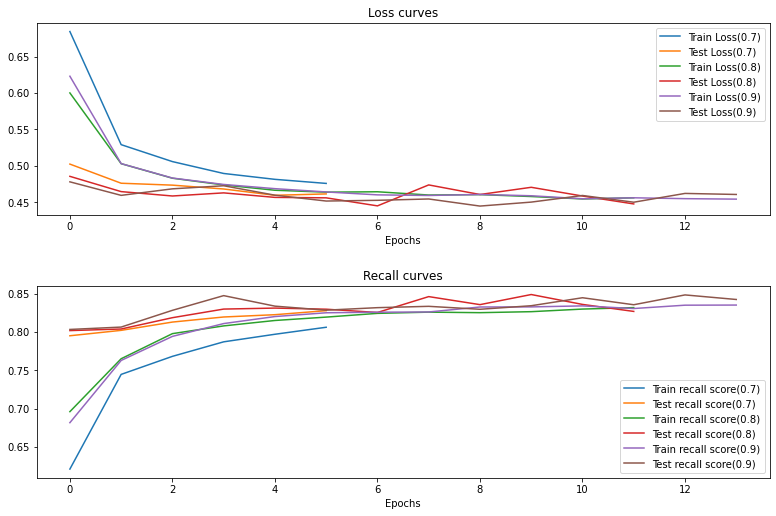

In [155]:
# Plot train and test loss curves
fig,axes = plt.subplots(2,1,figsize = (12,8))
fig.tight_layout(pad = 5)

# Plot loss curves
axes[0].plot(history_pca_07.history['loss'],label = 'Train Loss(0.7)')
axes[0].plot(history_pca_07.history['val_loss'],label = 'Test Loss(0.7)')
axes[0].plot(history_pca_08.history['loss'],label = 'Train Loss(0.8)')
axes[0].plot(history_pca_08.history['val_loss'],label = 'Test Loss(0.8)')
axes[0].plot(history_pca_09.history['loss'],label = 'Train Loss(0.9)')
axes[0].plot(history_pca_09.history['val_loss'],label = 'Test Loss(0.9)')
# Set title
axes[0].set_title('Loss curves')
# Set x label
axes[0].set_xlabel('Epochs')
axes[0].legend()

# Plot train and test recall curves
axes[1].plot(history_pca_07.history['recall_m'],label = 'Train recall score(0.7)')
axes[1].plot(history_pca_07.history['val_recall_m'],label = 'Test recall score(0.7)')
axes[1].plot(history_pca_08.history['recall_m'],label = 'Train recall score(0.8)')
axes[1].plot(history_pca_08.history['val_recall_m'],label = 'Test recall score(0.8)')
axes[1].plot(history_pca_09.history['recall_m'],label = 'Train recall score(0.9)')
axes[1].plot(history_pca_09.history['val_recall_m'],label = 'Test recall score(0.9)')
# Set title
axes[1].set_title('Recall curves')
# Set x label
axes[1].set_xlabel('Epochs')
axes[1].legend();

#### Comparison of recall and ROC-AUC scores across models with PCA
Table that compares the metric scores with optimal n_component for each model

|Models |CV recall score |Train recall score |Test recall score |Train ROC-AUC | Test ROC-AUC | PCA(n_components) |
|---	|---	  |---	       |---	            |---	    |---        | ---
|Logistic Regression 	|0.776 |0.777          	|0.799   	|0.775   	|0.787   | 0.8 | 
|XGBoost 	            |0.921 |0.999          	|0.940  	|0.881   	|0.743   | 0.5 | 
|Random Forest 	        |0.824 |0.861          	|0.839   	|0.807   	|0.771   | 0.5 |
|Extra Trees   	        |0.840 |0.870   	    |0.856   	|0.797   	|0.770   | 0.8 |  
|k-NN                   |0.733 |0.744 	        |0.750   	|0.769   	|0.771   | 0.5 |
|Neural Nets            |0.702 |0.843           |0.836      |0.799      |0.790   | 0.8 |   


Based on the table above, the **ExtraTrees Classifier** would be the optimal model as it exhibits high metric scores and less overfitting when comparing the CV recall score and train recall score. 

### Optimized Model: ExtraTrees Classifier

| Model | PCA(n_components) | Hyperparameters 
|---	| :--	  |:---	       
|ExtraTrees Classifier | 0.8 | class_weight: balanced, max_depth: 40, max_features: auto, min_samples_leaf: 20, n_estimators: 150 |

#### Explained variance - Amount of information captured by each principal component
Components with larger variance equates to greater importance as there is more spread of data in that direction

In [63]:
# Keeping 80% of variance
pca = PCA(0.8)
pca.fit(X_train_us,X_test_ss)
var_exp = pca.explained_variance_ratio_

print(f'''Explained variance(10 components): 
{var_exp[:10]}''')
print('')

cum_var_exp = np.cumsum(var_exp)

print(f'''Cumulative explained variance: 
{cum_var_exp}''')
print('')

print(f'Number of PCA that explains 80% of variance: {len(cum_var_exp)}')

Explained variance(10 components): 
[0.08466017 0.04436398 0.03377328 0.03026345 0.02913236 0.02548432
 0.02165153 0.01972973 0.01884028 0.01692408]

Cumulative explained variance: 
[0.08466017 0.12902415 0.16279743 0.19306088 0.22219324 0.24767756
 0.26932909 0.28905882 0.3078991  0.32482318 0.3410589  0.3559689
 0.37075982 0.3847932  0.3985738  0.41195214 0.42518971 0.43804671
 0.45071596 0.46265228 0.47443919 0.4858868  0.49731697 0.50864144
 0.5198502  0.53092321 0.54195714 0.55264497 0.56318211 0.57355778
 0.58385762 0.59402909 0.60408473 0.61392497 0.62367956 0.63335424
 0.64287279 0.65224591 0.66155125 0.67069513 0.67982023 0.68884721
 0.69776726 0.70665118 0.71538696 0.72410318 0.73271427 0.74120177
 0.74963663 0.75803287 0.76628852 0.7744418  0.78235947 0.79023525
 0.79800663 0.80572632]

Number of PCA that explains 80% of variance: 56


#### Predicting with final model

In [39]:
# Retaining 80% of variance in dataset gave the best model
X_train_pca,X_test_pca = pca_ratio(0.8,X_train_us,X_test_ss)

# Instantiate ExtraTrees Classifier model with optimal hyperparamters 
model = ExtraTreesClassifier(class_weight='balanced', max_depth=40,max_features='auto',min_samples_leaf=20,n_estimators = 150)
model.fit(X_train_pca,y_train_us)

# Generating new columns for both predictions and associated probabilities
test_df = pd.concat([X_test,y_test],axis = 1)
test_df['preds_prob'] = model.predict_proba(X_test_pca)[:,1]
test_df['preds'] = [i for i in model.predict(X_test_pca)]


#### ROC-AUC curve

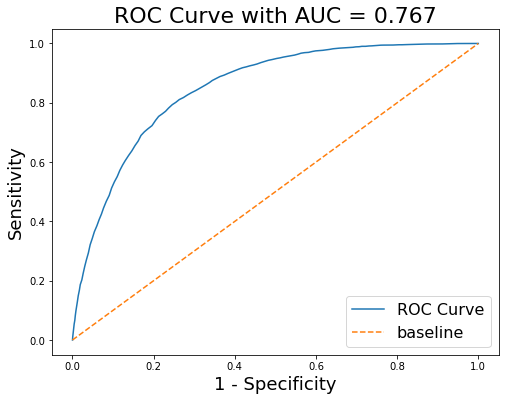

In [40]:
# Create figure for AUC ROC graph
plt.figure(figsize = (8,6))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(test_df, 'MH_NOTGET', 'preds_prob', prob) for prob in thresholds]
fpr_values = [FPR(test_df, 'MH_NOTGET', 'preds_prob', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(test_df["MH_NOTGET"], test_df["preds"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

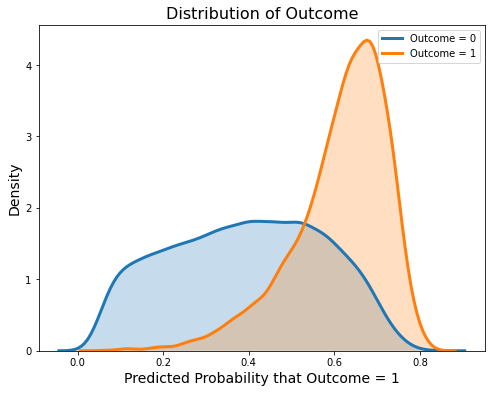

In [41]:
plt.figure(figsize = (8,6))

# Draw the density plot
sns.distplot(test_df[test_df['MH_NOTGET'] == 0]['preds_prob'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = 'Outcome = 0')
sns.distplot(test_df[test_df['MH_NOTGET'] == 1]['preds_prob'], hist = False, kde = True,
                 kde_kws = {'shade': True,'linewidth': 3},
                 label = 'Outcome = 1')
# Plot formatting
plt.title('Distribution of Outcome', size=16)
plt.ylabel('Density', size=14)
plt.xlabel('Predicted Probability that Outcome = 1', size=14)
plt.legend(loc = 'upper right');

#### Looking into wrongly classified rows in test set

In [63]:
# Looking at the wrongly classified rows
incorrect_preds = test_df[['DOWN','ANXIOUS','TBIRTH_YEAR','MH_NOTGET','PRESCRIPT_Yes','PRESCRIPT_No','DELAY_Yes','DELAY_No','EGENDER','preds_prob','preds']][test_df['MH_NOTGET'] != test_df['preds']]
incorrect_preds

DOWN  ANXIOUS  TBIRTH_YEAR  MH_NOTGET  PRESCRIPT_Yes  PRESCRIPT_No  \
80104   2.0      2.0         1969        0.0              0             1   
2333    1.0      2.0         1967        1.0              0             1   
65249   3.0      4.0         1963        0.0              1             0   
8839    2.0      2.0         1975        0.0              1             0   
14276   2.0      3.0         1977        0.0              0             1   
...     ...      ...          ...        ...            ...           ...   
19119   2.0      2.0         1987        0.0              0             1   
68756   2.0      3.0         1967        0.0              0             1   
4993    2.0      2.0         1971        0.0              0             1   
37178   3.0      3.0         1957        0.0              0             1   
34196   4.0      4.0         1962        0.0              0             1   

       DELAY_Yes  DELAY_No  EGENDER  preds_prob  preds  
80104          0         1        1    0.531683    1.0  
2333           1         0        1    0.445207    0.0  
65249          0         1        0    0.611333    1.0  
8839           1         0        1    0.581126    1.0  
14276          1         0        1    0.591335    1.0  
...          ...       ...      ...         ...    ...  
19119          1         0        1    0.616410    1.0  
68756          0         1        1    0.506429    1.0  
4993           0         1        0    0.579322    1.0  
37178          1         0        1    0.611385    1.0  
34196          1         0        1    0.671070    1.0  

[7055 rows x 11 columns]

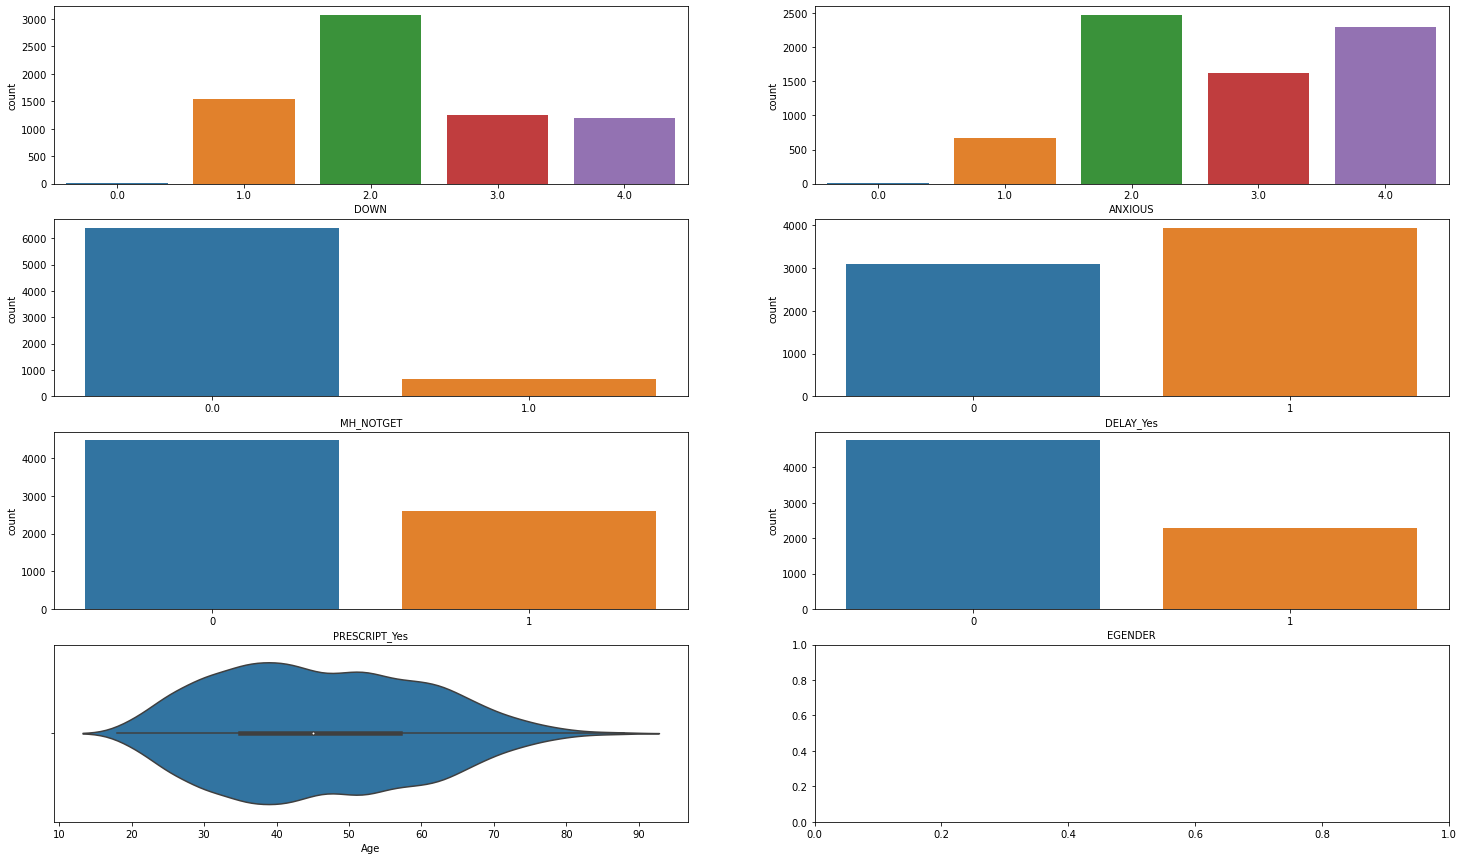

In [71]:
# Statistical summary of various important features in predictions generated
fig,axes = plt.subplots(4,2,figsize = (25,15))
sns.countplot(incorrect_preds['DOWN'],ax = axes[0,0])
sns.countplot(incorrect_preds['ANXIOUS'],ax = axes[0,1])
sns.countplot(incorrect_preds['MH_NOTGET'],ax = axes[1,0])
sns.countplot(incorrect_preds['DELAY_Yes'],ax = axes[1,1])
sns.countplot(incorrect_preds['PRESCRIPT_Yes'],ax = axes[2,0])
sns.countplot(incorrect_preds['EGENDER'],ax = axes[2,1])

# Converting TBIRTH_YEAR to age
age = 2020 - incorrect_preds['TBIRTH_YEAR']
sns.violinplot(age,ax = axes[3,0]).set_xlabel('Age');

In [72]:
# Mean age of the respondents in the dataset
age_df = 2020 - df['TBIRTH_YEAR'] 
print(f'Mean age of respondents in entire dataset: {round(age_df.mean(),1)}')

# Mean age of false positives
age = 2020 - incorrect_preds['TBIRTH_YEAR']
print(f'Mean age of respondents in false positives: {round(age.mean(),2)}')

Mean age of respondents in entire dataset: 50.6
Mean age of respondents in false positives: 46.02


#### Findings 
1) The model predicted many false positives (predicted that people did not seek help even though they indicated the opposite) <br>
2) Majority of them have high `ANXIOUS` values <br>
3) Average age of respondents in false positives is lower than that of the entire population <br> 
4) Majority of them are females <br>

#### Possible reason for false positives

In [80]:
# Proportion of respondents who should be re-looked
need_help = incorrect_preds[(incorrect_preds['DOWN'] >= 3) & (incorrect_preds['ANXIOUS']>=3) & (incorrect_preds['PRESCRIPT_Yes'] == 1)]
need_help['MH_NOTGET'].value_counts()[0]/len(incorrect_preds) * 100

12.57264351523742

The high number of false positives generated(due to low F1 score) could be due to a subjective perception of the mental health status of respondents whereby around 12% of the wrong predictions show signs of mental health distress(high `DOWN`, high `ANXIOUS`, take prescriptions(`PRESCRIPT_YES` = 1) but indicated that they do not exhibit avoidance behaviours(`MH_NOTGET` = 0) Therefore, these results can be re-evaluated as it could be due to a lack of awareness of the presence of mental health issues among these respondents.

#### Threshold moving
Tuning the threshold used to map probabilities to a class labels for imbalanced classes as 0.5 might not be the optimal interpretation of the predicted probabilities. This could help better separate true positive rate from false positive rates. The geometric mean is a common metric used for imbalanced classification which helps to seek a balance between sensitivity and the specificity.

In [85]:
predictions = model.predict_proba(X_train_pca)
fpr, tpr, thresholds = roc_curve(y_train_us, predictions[:,1])

# Calculating the optimal threshold using gmean

gmeans = np.sqrt(tpr * (1-fpr))
ix = argmax(gmeans)
print(f"Best Threshold: {thresholds[ix]:.3f}, G-Mean: {gmeans[ix]:.3f}")

Best Threshold: 0.544, G-Mean: 0.804


In [96]:
# Adjusting threshold 
test_df['preds_prob_adjusted'] = test_df['preds_prob'].apply(lambda x: 1 if x > 0.544 else 0)

In [97]:
print("Before adjusting threshold:")
print('------------------------------')
print(f'Test recall score: {round(recall_score(test_df.MH_NOTGET,test_df.preds),4)}')
print(f'Test F1 score: {round(f1_score(test_df.MH_NOTGET,test_df.preds),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(test_df.MH_NOTGET,test_df.preds_prob),4)}')
print('')
cm = confusion_matrix(test_df['MH_NOTGET'],test_df['preds'])
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')
cm_df

Before adjusting threshold:
------------------------------
Test recall score: 0.8515
Test F1 score: 0.5127
Test ROC-AUC:0.8497

Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        13816                         6408
actual_does_not_get_help                  647                         3711

In [98]:
print("After adjusting threshold: ")
print('------------------------------')
print(f'Test recall score: {round(recall_score(test_df.MH_NOTGET,test_df.preds_prob_adjusted),4)}')
print(f'Test F1 score: {round(f1_score(test_df.MH_NOTGET,test_df.preds_prob_adjusted),4)}')
print(f'Test ROC-AUC:{round(roc_auc_score(test_df.MH_NOTGET,test_df.preds_prob_adjusted),4)}')
print('')
cm = confusion_matrix(test_df['MH_NOTGET'],test_df['preds_prob_adjusted'])
cm_df = pd.DataFrame(data = cm, columns = ['predicted_gets_help','predicted_does_not_get_help'],index = ['actual_gets_help','actual_does_not_get_help'])
print('Confusion matrix:')

cm_df

After adjusting threshold: 
------------------------------
Test recall score: 0.7788
Test F1 score: 0.543
Test ROC-AUC:0.772

Confusion matrix:


predicted_gets_help  predicted_does_not_get_help
actual_gets_help                        15475                         4749
actual_does_not_get_help                  964                         3394

The reduction in ROC-AUC and recall scores is drastic compared to the increase in F1 score and thus it would not be justifiable to shift the threshold.

## Findings and Insights

#### Visualizing distribution of target variable:
`MH_NOTGET`
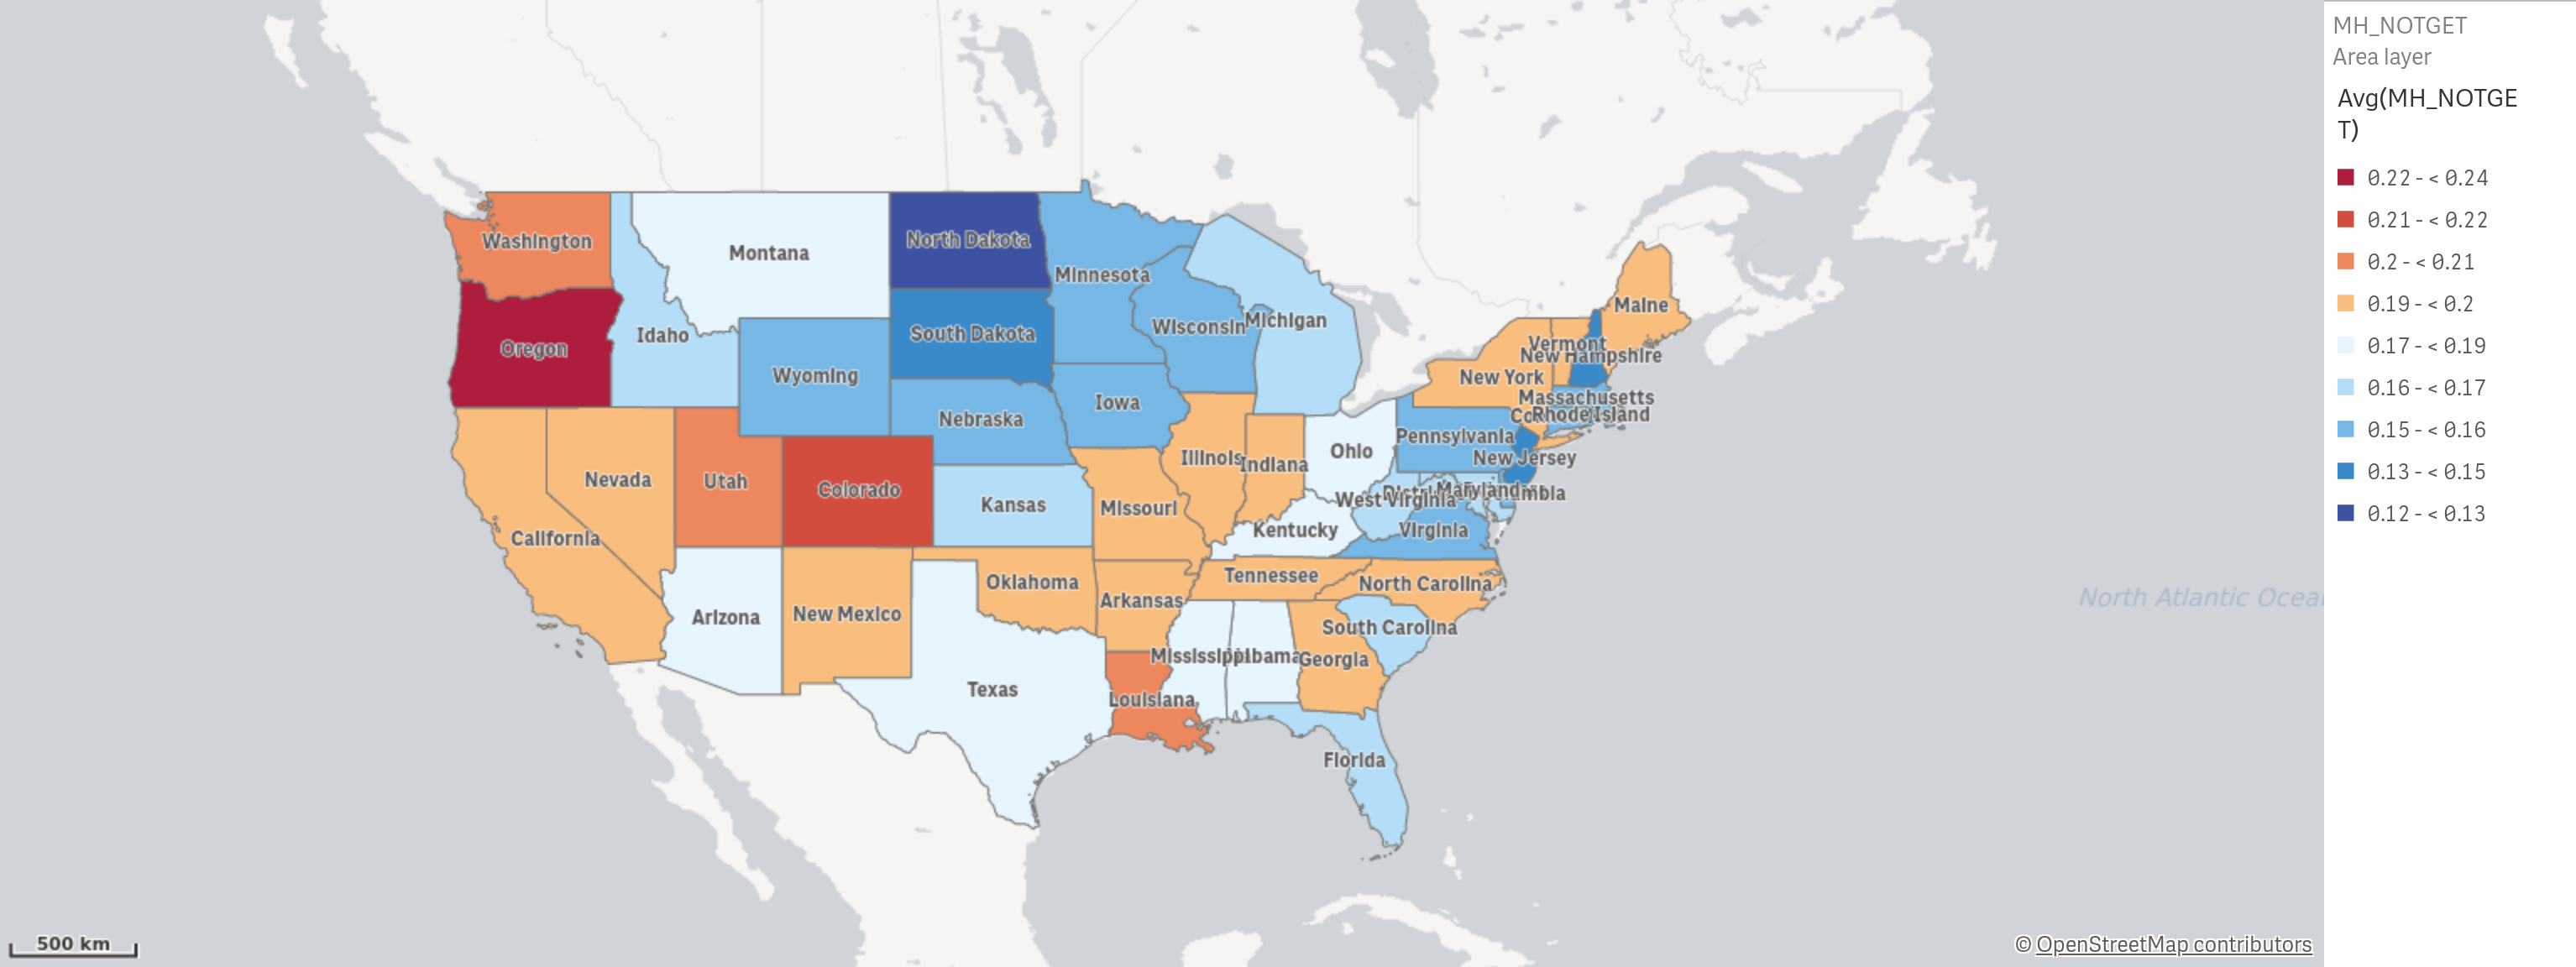

On average, 20% of the respondents in Oregon, Washington, Colorado, Lousiana are likely to refrain from seeking professional mental services. Whereas this phenomenon is less likely to occur in areas such as North Dakota and South Dakota.

#### Visualizing distribution of the top predictor variables:
`ANXIOUS`
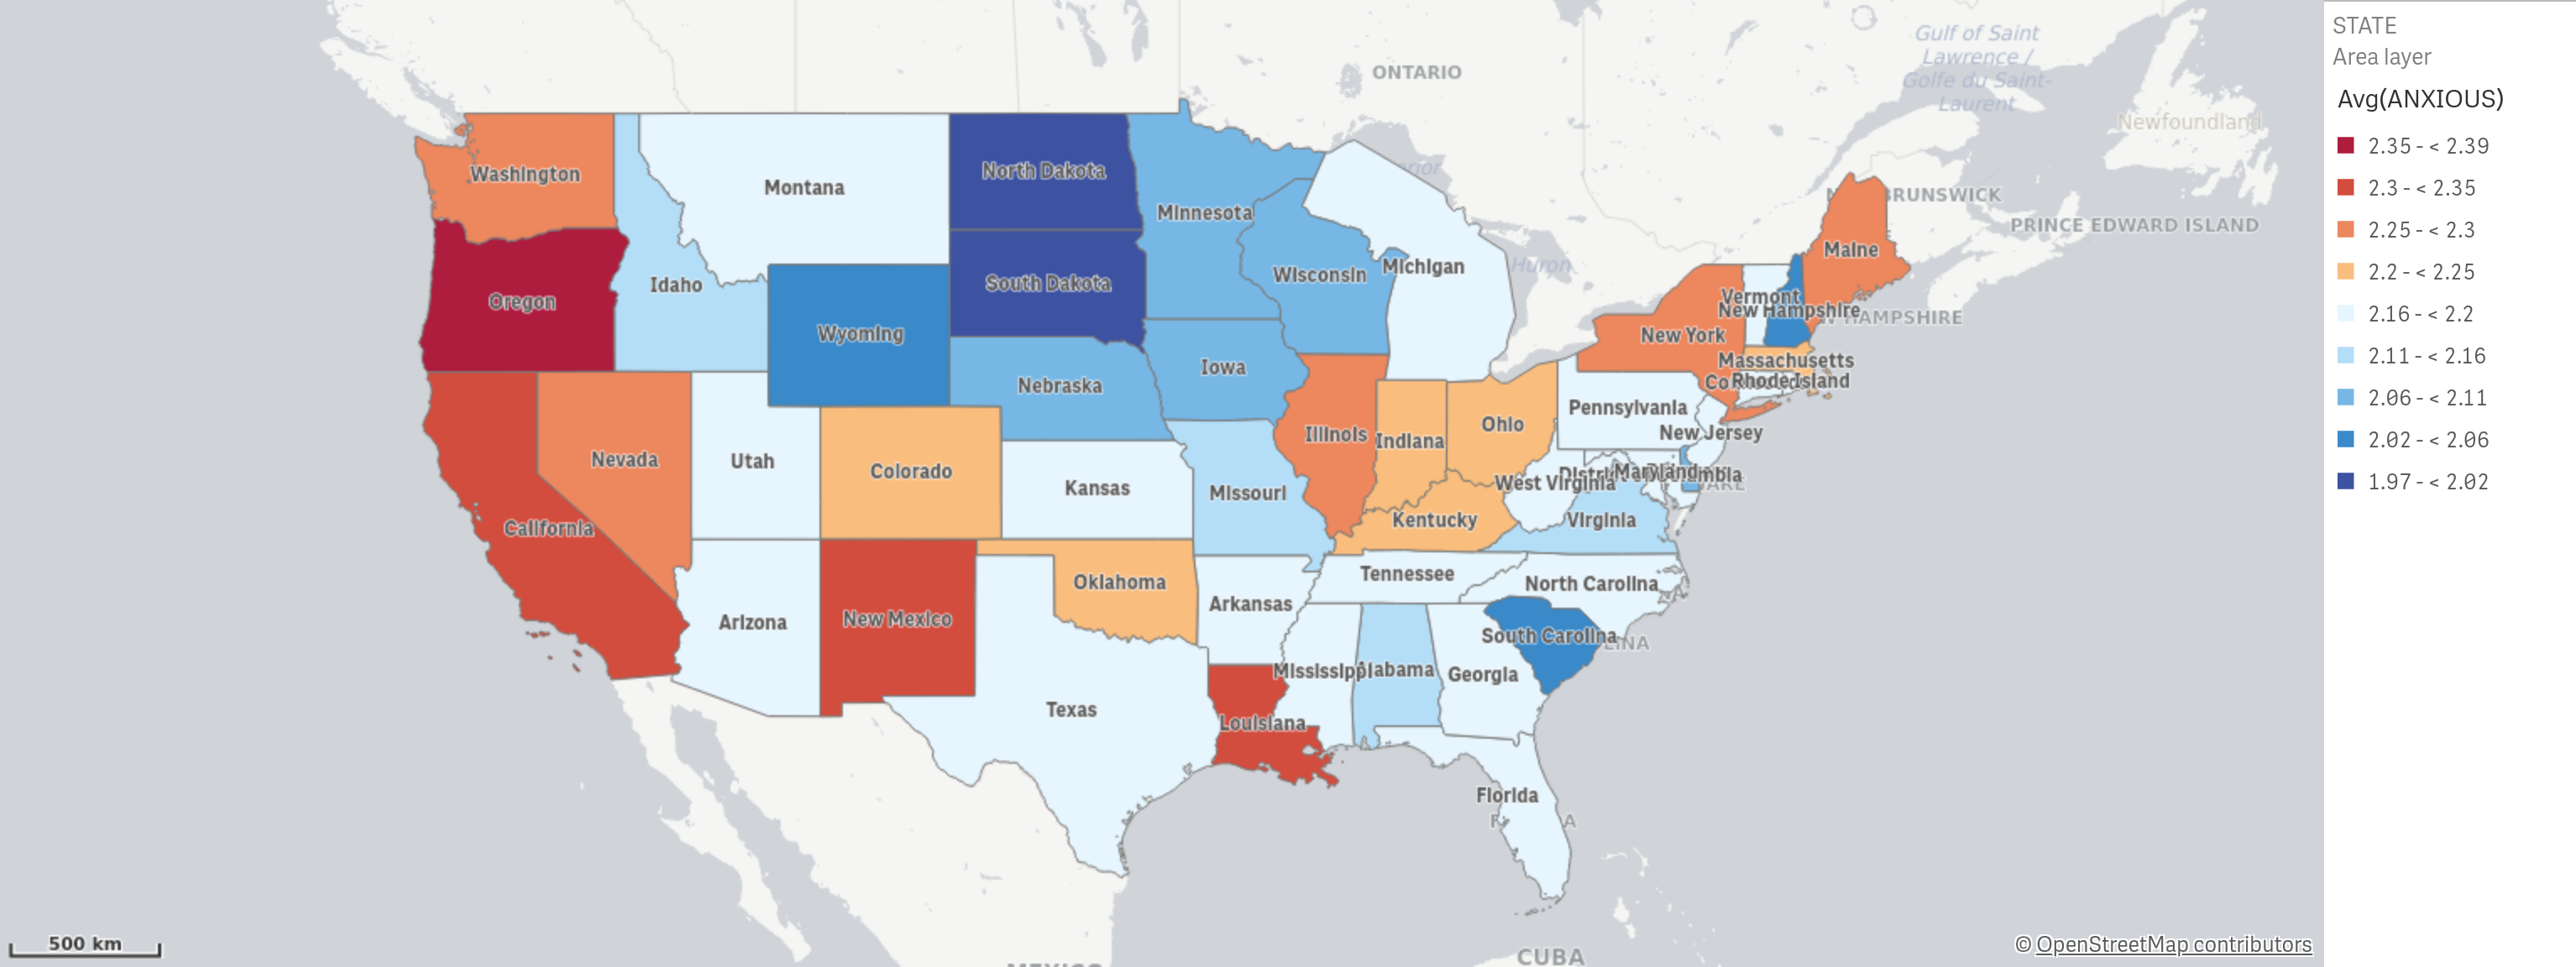

This heatmap on the average levels of anxiety across the states is a close reflection of that with target variable. In particular, Oregon has the highest state of average anxiety level as well as average `MH_NOTGET`. Other states such as Louisana and Washington which were identified to have higher `MH_NOTGET` also show higher levels of anxiety. On the other end of the spectrum, North Dakota and South Dakota exhibit low levels of anxiety which mirror their average `MH_NOTGET`. Therefore, there seems to be correlation between higher levels of anxiety and avoidance of mental health aid. However, Utah seems to have be an anomaly as despite having a median anxiety level, the average `MH_NOTGET` is on the higher end.

`DOWN`
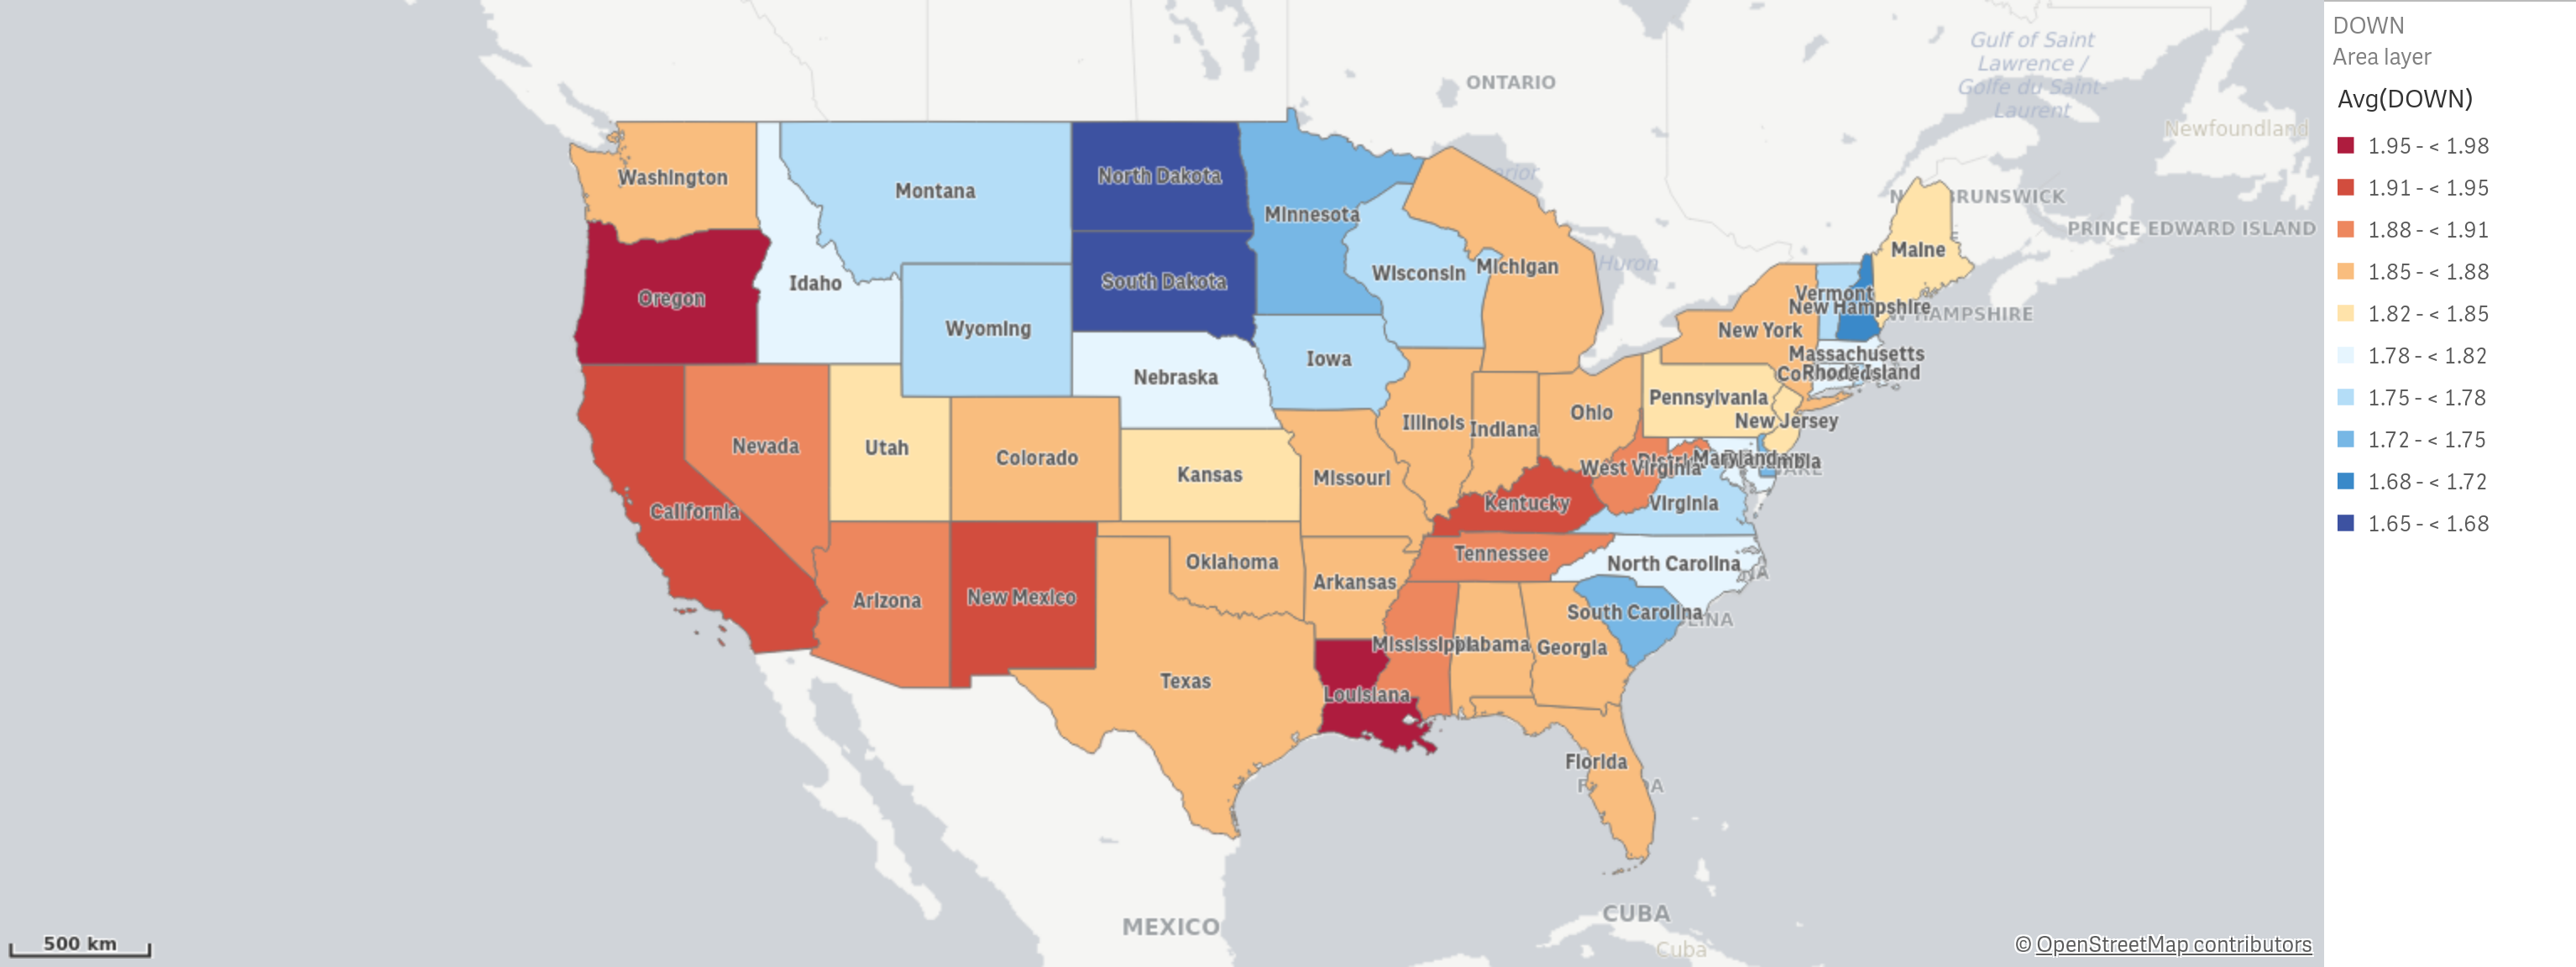

Similarly, the average `DOWN` values mirror that of the average `ANXIOUS` levels. Therefore, there is a correlation between greater frequency of feeling down and avoidance of seeking mental health therapy. Interestingly, Kentucky shows a higher level of average `DOWN` and `ANXIOUS` but has a lower `MH_NOTGET` value.

`TBIRTH_YEAR`/Age
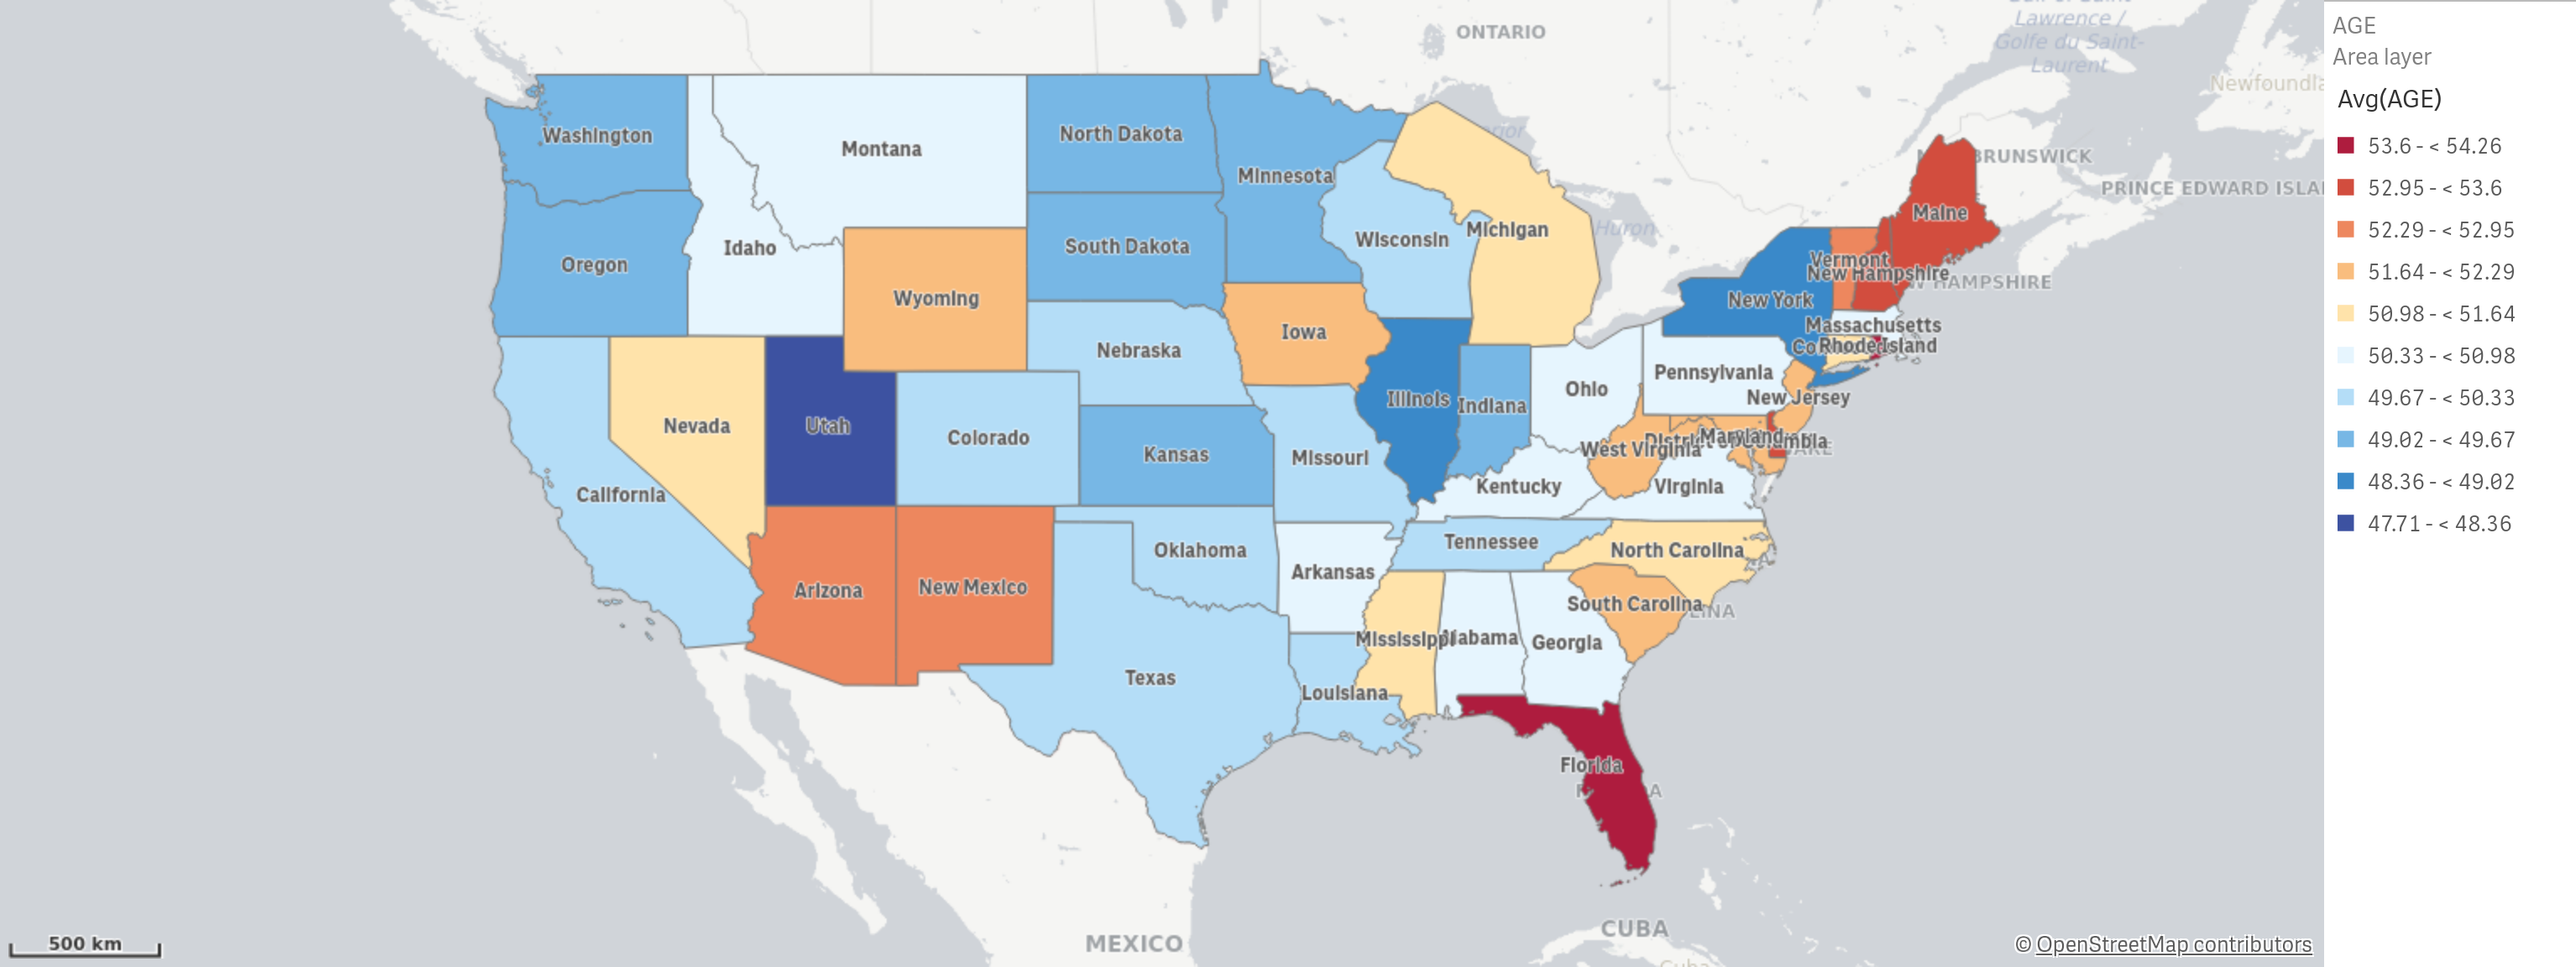

In [108]:
# Grouping respondents by `MH_NOTGET` and calculating average age
age = 2020 - df.groupby('MH_NOTGET')['TBIRTH_YEAR'].mean()
print(f'Average age of respondents that do not exhibit avoidance behaviours: {round(age[0],1)}')
print(f'Average age of respondents that exhibit avoidance behaviours: {round(age[1],1)}')

Average age of respondents that do not exhibit avoidance behaviours: 52.0
Average age of respondents that exhibit avoidance behaviours: 44.2


There seems to be a weak negative correlation between age and `MH_NOTGET` as places with a lower average age such as Washington, Oregon, Utah, Illinois generally show higher levels of `ANXIOUS`,`DOWN` and `MH_NOTGET`. Places with an older population such as Florida, New Hampshire, Vermont show lower levels of `ANXIOUS`,`DOWN` and `MH_NOTGET`. Interestingly, age does not seem to be a strong indicator as despite having low `ANXIOUS` and `DOWN` in North Dakota and South Dakota, the average age is on the lower end.

## Conclusion

#### 1) Implementation of logistic regression for feature importance
The logistic regression is advantageous in quantifying the strength and direction of each feature in determining the target variable unlike the ExtraTrees and RandomForests. Feature importances identified by the ensemble learning methods are not interpretable in helping to generate predictions or for analysis. However, the coefficients generated by logistic regression allows us to understand how the predictor variables contribute to the target variable. Even though the ROC-AUC and recall scores of logistic regression are lower than that of the ensemble methods, there is less overfitting in logistic regression and thus able to generalize better to unseen data. Therefore, logistic regression was selected as the final model for inference.

#### 2) Important predictor variables that determine `MH_NOTGET`
The model identified two features, `DOWN` and `ANXIOUS` and they are consistent with the most common symptoms of mental illnesses. Anxiety disorders are the most common mental illness in the States and they are characterized by persistently high levels of anxiety across an extended period of time, affecting around 40 million people in the United States every year. Even though these disorders are highly treatable, only 36.9% of them are seeking help. Similarly, an extended period of feeling hopeless, sad and depressed is one of the tell-tale signs of depression, and this disorder is a leading cause of disability among those age 15-44. The average age of respondents that refrained from seeking help happened to be within this range as well. <br>

There are other features such as gender which was identified to be correlated with `MH_NOTGET`. This finding is consistent with external studies that report a higher prevalence of depression and anxiety among females.

Interestingly, those who are under medication(`PRESCRIPT`) to cope with their behaviour/mental heath are less likely to seek help from mental health professionals whereas those who are not under medication are more likely to seek help. This could be due to the reduction in social interactions as a result of the pandemic and thus people are opting for medications as a substitute instead.

Lastly, those who delay seeking help(`DELAY`) are more likely to develop such an avoidance behaviour whereas those who do seek help are less inclined to. This is consistent with external studies which explains that 1 in 4 people delay seeking help because of inaccurate assumptions or misconceptions of symptoms even though these disorders are highly treatable. The recent pandemic would only perpetuate such a behaviour and thus is a great cause of worry.

#### 3) Implementation of ExtraTrees Classifier for predictions

The model chosen to for predictive purposes would be the ExtraTrees Classifier with its optimal tuned hyperparameters. Although most of the models have shown comparable ROC-AUC and recall scores, this classifier exhibited an optimal balance of bias-variance tradeoff and thus it is best able to generalize to unseen data. Even though the performance of RandomForests was similar to the ExtraTrees, it was time consuming to run the former and thus deployment of ExtraTrees would be computationally efficient. Looking at the low F1 score but high recall score on the test set, the model is predicting many false positives in the test set. Further examination of these incorrectly indentified rows show that around 12% of them exhibited tell-tale signs of avoidance behaviours even though they have indicated otherwise. Since several research studies have supported the existence of such a phenomenon where people have misdiagnosed their mental conditions, it would be worthwhile to look into these wrongly classified rows. Therefore, this model would simulatenously help to re-evaluate past results and generate future predictions to not only delay but cease the growth of mental health issues.

## Recommendations
Based on the features identified to have strong correlations with our target variable(`DOWN`,`ANXIOUS`,`TBIRTH_YEAR`), they would be the deciding factors for the states chosen where these models could be implemented. This would help to narrow our target population and provide a greater understanding of the magnitude of spread of mental health disorders when models are fed with state-specific data. Therefore, local health departments can make well-informed decisions on resource allocation according to the needs of different states

#### 1) Implement models in a state that requires immediate aid - Oregon
Before these models are used on a larger scale, it would be more effective to deploy the model in a state that requires urgent intervention. One such example would be Oregon as it has marked the checkbox on high `DOWN` and `ANXIOUS` values and a comparatively younger population. Moreover, MHA has ranked Oregon as the worst in the States even before the pandemic for accessibility to mental health and the highest in terms of mental illness rates. This is accompanied by the highest rate of homelessness, high school graduates and child abuse in Oregon which impacts mental health. The lack of undivided attention on the overwhelming demands of mental health aid due to the recent pandemic would only contribute to this existing widespread phenomenon. Therefore, more surveilance and resources have to be channelled to Oregon's health system.

#### 2) Implement models in states that show similar characteristics - Utah, Illinois
These states have been identified to have `DOWN` and `ANXIOUS` on the higher end of the scale and also relatively younger populations. In 2018, Utah was ranked as the worst state in a national analysis of mental health measures by MHA and the ratio of mental heath professionals to residents is below national average. Given that there is also a steady increase in the state's population, there is an urgent need to allocate more resources to residents in Utah. Residents in Illinois are facing a similar issue where there is a shortage of behavioural healthcare professional as well as a lower per capita expenditure on mental health services. Therefore, models could be used in such states to identify state specific vulnerable groups and thus provide appropriate assistance.

To conclude, mental health consequences of the recent pandemic has called for a greater surveillance,intervention and prevention of such a substantial increase in mental health disorders. Therefore, these models developed would be a helpful reference to identify susceptible groups of people who are likely to require mental health therapy.

### Limitations of models
**1) Self-reported assessment of mental health conditions:** <br>
Since data collected is heavily subjected to the biases of respondents especially with regards to mental health, models developed should only be used as a reference. Evaluation of a mental health condition should be done by a certified professional and ideally through objective measurements. One example would be on a recent study using MRI scans which have identified a promising biomarker involving the blood-brain barrier in patients with major depression. However, such experiments are still in their early stages and thus small in scale so more data has to be collected before machine learning models can be utilized to improve detection. 

**2) Imbalanced classes:** <br>
Undersampling was done to randomly reduce the number of rows in the majority class but doing so would disregard important features present in the training set. Therefore, more data needs to be collected to further improve on the performances of such models. 

## References
--- 
1) K.Smith, V. (2020). How New York is battling a second crisis alongside COVID-19: Mental health. CityWatch. https://www.marketwatch.com/story/how-new-york-is-battling-a-second-crisis-alongside-covid-19-mental-health-2020-04-21 <br>
2) Levine, D. S., & Willner, S. G. (1976). The cost of mental illness, 1974. Mental Health Statistical Note, 125, 1–7. <br>
3) Heun-Johnson, H., Menchine, M., Goldman, D., & Seabury, S. (2017). The Cost of Mental Illness Illinois Facts and Figures. State-Level Chart Books on the Cost of Mental Illness, February. https://healthpolicy.usc.edu/research/state-level-chart-books-on-the-cost-of-mental-illness/ <br>
4) Cheang, J. (2018). The Best And Worst States For Mental Health. Mental Health America. https://www.mhanational.org/blog/best-and-worst-states-mental-health <br>
5) MHA. (2020). 2021 COVID-19 and Mental Health: A Growing Crisis. https://mhanational.org/sites/default/files/Spotlight 2021 - COVID-19 and Mental Health.pdf <br>
6) ADAA. (n.d.). Facts & Statistics. ADAA. https://adaa.org/about-adaa/press-room/facts-statistics#:~:text=Anxiety disorders are the most,of those suffering receive treatment <br>
7) Anxiety Disorders. (n.d.). National Institute of Mental Health. https://www.nimh.nih.gov/health/topics/anxiety-disorders/index.shtm <br>
8) Symptoms of Depression. (n.d.). WedMDE. https://www.webmd.com/depression/guide/detecting-depression#1<br>
9) Amy Morin, L. (2020). Depression Statistics Everyone Should Know. Verywellmind. https://www.verywellmind.com/depression-statistics-everyone-should-know-4159056 <br>
10) Number of people reporting anxiety and depression nationwide since start of pandemic hit all-time high in September, hitting young people hardest. (2020, October 20). Mental Health America. https://www.globenewswire.com/news-release/2020/10/20/2111263/0/en/Number-of-people-reporting-anxiety-and-depression-nationwide-since-start-of-pandemic-hit-all-time-high-in-September-hitting-young-people-hardest.html <br>
11) Mental health. (2002). Medicine Today, 3(6), 9. <br>
12) Webber, A. (2018). One in four delay seeking help for mental health because of misconceptions. Personneltoday. https://www.personneltoday.com/hr/one-in-four-delay-help-mental-health-misconceptions/#:~:text=A-quarter-of-people-have,by-Bupa-UK-has-revealed <br>
13) Curley, B. (2019). MRI Scans May Pick Up Brain Abnormalities in People with Depression. Healthline. https://www.healthline.com/health-news/mri-detects-abnormalities-in-brain-depression <br>
14) Sandro Galea, ; Raina M. Merchant, N. L. (2020). The Mental Health Consequences of COVID-19 and Physical Distancing The Need for Prevention and Early Intervention. JAMA Network. https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2764404 <br>
15) Mehlhaf, N. (2017, June 14). Oregon ranks worst in US for mental health, study says. KGW8. https://www.kgw.com/article/news/local/oregon-ranks-worst-in-us-for-mental-health-study-says/283-449141620 <br>
16) Alberty, E. (2019, August 14). Report: Utah ranks near the bottom of the nation in many mental health measures. The Salt Lake Tribune. https://www.sltrib.com/news/2019/08/14/some-utah-communities/ <br>